In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_curve,
    auc,
    roc_auc_score,
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    pairwise_distances
)

from trackml.dataset import load_event, load_dataset
from trackml.randomize import shuffle_hits
from trackml.score import score_event

import xgboost as xgb

%matplotlib inline

In [2]:
event_id = 'event000001000'

In [3]:
hits, cells, particles, truth = load_event('../input/train_1/' + event_id)

In [4]:
print(hits.head(4))

   hit_id          x         y       z  volume_id  layer_id  module_id
0       1 -64.409897 -7.163700 -1502.5          7         2          1
1       2 -55.336102  0.635342 -1502.5          7         2          1
2       3 -83.830498 -1.143010 -1502.5          7         2          1
3       4 -96.109100 -8.241030 -1502.5          7         2          1


In [5]:
print(particles.head(20))

         particle_id        vx        vy        vz         px         py  \
0   4503668346847232 -0.009288  0.009861 -0.077879  -0.055269   0.323272   
1   4503737066323968 -0.009288  0.009861 -0.077879  -0.948125   0.470892   
2   4503805785800704 -0.009288  0.009861 -0.077879  -0.886484   0.105749   
3   4503874505277440 -0.009288  0.009861 -0.077879   0.257539  -0.676718   
4   4503943224754176 -0.009288  0.009861 -0.077879  16.439400 -15.548900   
5   4504011944230912 -0.009288  0.009861 -0.077879   0.795277  -1.685200   
6   4504080663707648 -0.009288  0.009861 -0.077879  -0.563433   0.305370   
7   4504355541614592 -0.009288  0.009861 -0.077879  -0.501267   0.049825   
8   4504424261091328 -0.009288  0.009861 -0.077879  -1.652120   0.453142   
9   4504492980568064 -0.009288  0.009861 -0.077879   0.035160   0.131420   
10  4504561700044800 -0.009288  0.009861 -0.077879  -0.249551  -0.434369   
11  4504630419521536 -0.009288  0.009861 -0.077879  -0.657957   0.258518   
12  45046991

In [6]:
zero_particles_ids_mask = particles['particle_id'] == 0
print(zero_particles_ids_mask.shape)

(12263,)


In [7]:
print(truth.head(4))

   hit_id         particle_id         tx        ty      tz            tpx  \
0       1                   0 -64.411598 -7.164120 -1502.5  250710.000000   
1       2   22525763437723648 -55.338501  0.630805 -1502.5      -0.570605   
2       3                   0 -83.828003 -1.145580 -1502.5  626295.000000   
3       4  297237712845406208 -96.122902 -8.230360 -1502.5      -0.225235   

             tpy           tpz    weight  
0 -149908.000000 -956385.00000  0.000000  
1       0.028390     -15.49220  0.000010  
2 -169767.000000 -760877.00000  0.000000  
3      -0.050968      -3.70232  0.000008  


In [8]:
track = 22525763437723648

#print(tracks)

In [9]:
particle_truth = truth[truth.particle_id == track]
print(particle_truth)

      hit_id        particle_id         tx        ty      tz       tpx  \
1          2  22525763437723648 -55.338501  0.630805 -1502.5 -0.570605   
1419    1420  22525763437723648 -55.154400  0.621779 -1497.5 -0.569794   
1459    1460  22525763437723648 -47.988098  0.315591 -1302.5 -0.568883   
3169    3170  22525763437723648 -47.804100  0.308733 -1297.5 -0.571445   
3233    3234  22525763437723648 -40.626099  0.087326 -1102.5 -0.569940   
5342    5343  22525763437723648 -40.442200  0.082538 -1097.5 -0.570204   
5423    5424  22525763437723648 -35.475899 -0.024284  -962.5 -0.569773   
5481    5482  22525763437723648 -35.310101 -0.027160  -958.0 -0.571644   
7866    7867  22525763437723648 -35.291698 -0.027451  -957.5 -0.571617   
7950    7951  22525763437723648 -30.315399 -0.095482  -822.5 -0.570993   

           tpy      tpz    weight  
1     0.028390 -15.4922  0.000010  
1419  0.027264 -15.4928  0.000008  
1459  0.021994 -15.4929  0.000006  
3169  0.020847 -15.4933  0.000005  
3233 

In [10]:
tracks = truth.particle_id.unique()[1::100]
unique_truth_particles_id = truth.particle_id.unique()
print(unique_truth_particles_id.shape)
print(tracks)
len(tracks)

(10566,)
[ 22525763437723648 968285258598318080  63067986969231360
 220695210877779968 968284227806167040 864705696984203264
 761108818061950976 211670419436994560  90072198705840128
 954766350817951744 166640607916195840 932250757862785024
  94576897844838400 292754110585765888 337787014483017728
 837672829225795584 301748253156708353 864699374792343552
 432349618676695040 662038697230729216 693556679077265408
 364801465438441473 166637103222882304 968279692320702464
 445867220787003392 707065691252981760 211671587668099072
 648522744387862528 495396165169184768 927744890492682240
 747611282038849536   4504561700044800  45038126577483776
 860189246814683136 635008715690344448   4517480961671168
 418860122832371712 589974437403557888 941255208338456576
 851185277375348736 454876962662383616 409831620539842560
 211669594803273728 860190140167880704 761111085804683264
 963770732574146560 427842514356011008   4519061509636096
 788131996374138880 801658188419039232 139619697346740224
 3017

106

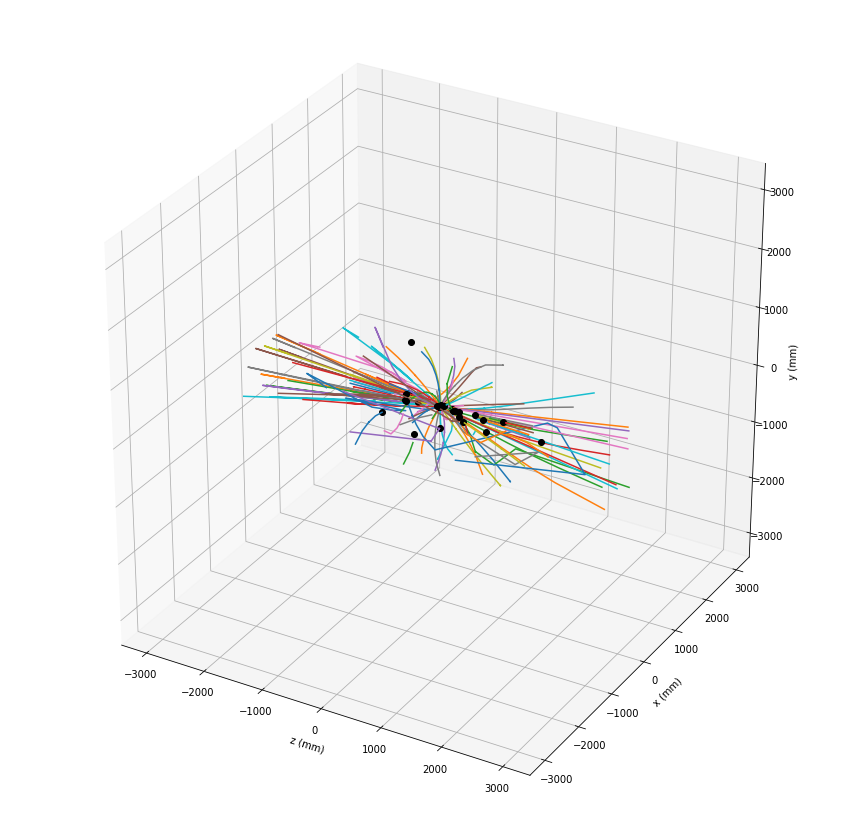

In [11]:
plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')

for i, track in enumerate(tracks):
    particle_origin = particles[particles.particle_id == track]
    #print(particle_origin)
    particle_truth = truth[truth.particle_id == track]
    ax.plot3D(
        particle_origin.vz,
        particle_origin.vx,
        particle_origin.vy,
        marker='o',
        color='black',
        label=str(i)
    )
    ax.plot3D(particle_truth.tz, particle_truth.tx, particle_truth.ty)
ax.scatter(3000, 3000,3000, s=0)
ax.scatter(-3000, -3000, -3000, s=0)
ax.set_xlabel("z (mm)")
ax.set_ylabel("x (mm)")
ax.set_zlabel("y (mm)")
plt.show()

In [12]:
class Clusterer(object):
    
    def __init__(self, eps):
        self.eps = eps
    
    def _preprocess(self, hits):
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values
        
        r = np.sqrt(x**2 + y**2 + z ** 2)
        hits['x2'] = x/r
        hits['y2'] = y/r
        
        r = np.sqrt(x**2 + y**2)
        hits['z2'] = z/r
        
        ss = StandardScaler()
        
        X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
        
        return X
    
    def predict(self, hits):
        
        X = self._preprocess(hits)
        cl = DBSCAN(eps=self.eps, min_samples=1, algorithm='kd_tree')
        labels = cl.fit_predict(X)
        
        return labels
        

In [13]:
model = Clusterer(eps=0.008)
labels = model.predict(hits)

In [14]:
print(labels)

[    0     1     2 ..., 63717 63718 14116]


In [15]:
def create_one_event_submission(event_id, hits, labels):
    submission_data = np.column_stack(
        (
            [event_id] * len(hits),
            hits.hit_id.values,
            labels
        )
    )
    submission = pd.DataFrame(
        data=submission_data,
        columns=('event_id', 'hit_id', 'track_id')
    ).astype(int)
    return submission

In [16]:
submission = create_one_event_submission(0, hits, labels)
score = score_event(truth, submission)

In [17]:
print("score: ", score)

score:  0.198855691365


In [18]:
particle0 = particles.iloc[0, :]

In [19]:
particle0

particle_id    4.503668e+15
vx            -9.288160e-03
vy             9.860980e-03
vz            -7.787890e-02
px            -5.526890e-02
py             3.232720e-01
pz            -2.034920e-01
q             -1.000000e+00
nhits          8.000000e+00
Name: 0, dtype: float64

In [20]:
particle0_truth = truth[truth['particle_id'] == particle0['particle_id']]

In [21]:
particle0_truth

hit_id       particle_id           tx          ty          tz  \
20879    20880  4503668346847232    -6.373050   31.601900  -20.080000   
29322    29323  4503668346847232   -16.962099   71.000504  -45.638100   
35620    35621  4503668346847232   -31.188400  112.045998  -73.201897   
42237    42238  4503668346847232   -54.559299  162.826004 -108.474998   
73762    73763  4503668346847232  -105.022003  240.369003 -166.449005   
80880    80881  4503668346847232  -177.020004  315.593994 -231.375000   
87264    87265  4503668346847232  -303.834015  396.170013 -325.032013   
113564  113565  4503668346847232 -1010.739990  125.904999 -862.786011   

             tpx       tpy       tpz    weight  
20879  -0.074873  0.319162 -0.203232  0.000018  
29322  -0.096428  0.311619 -0.204427  0.000014  
35620  -0.118230  0.302181 -0.206065  0.000010  
42237  -0.151918  0.287370 -0.204184  0.000008  
73762  -0.200451  0.254855 -0.201860  0.000005  
80880  -0.246460  0.210003 -0.201005  0.000005  
87264  -0.288603  0.130892 -0.198512  0.000009  
113564 -0.120391 -0.286054 -0.203332  0.000011

In [22]:
particle0_truth_first_hit_tx = particle0_truth.iloc[0, :]['tx']

In [23]:
particle0_truth_first_hit_tx

-6.3730502128601074

In [24]:
#for particle in particle_truth.iteritems?

In [25]:
#print(particles[particles['nhits'] == 0])

In [26]:
#for particle in particles.iterrows():
#    print(particle)
#

In [27]:
#pd.join?

In [28]:
#truth.join?

In [29]:
#joined_truth_particles = truth.join(particles, on='particle_id', lsuffix='_truth', rsuffix='_particle', on='right')
#joined_particles_truth = particles.join(truth, on='particle_id', lsuffix='_truth', rsuffix='_particle')

In [30]:
#joined_truth_particles
#oined_particles_truth
#rint(joined_particles_truth.shape)
#d.concat?

In [31]:
particle_ids = particles.loc[:, 'particle_id']

In [32]:
truth_first_hit_x_list = []
not_zero_truth_particle_ids = []
zero_truth_particle_ids = []
for particle_id in particle_ids:
    #print("\n\n before: ", particle_id)
    #print(truth[truth['particle_id'] == particle_id])
    particle_truth = truth[truth['particle_id'] == particle_id]
    if particle_truth.shape[0] != 0:
        #print(particle_truth.shape)
        truth_first_hit_x_list.append(truth[truth['particle_id'] == particle_id].iloc[0, :]['tx'])
        not_zero_truth_particle_ids.append(particle_id)
        #print("after: ", particle_id)
    else:
        #print("\n\n zero_truth_particle_id")
        zero_truth_particle_ids.append(particle_id)
        #particles[particles['particle_id' == particle_id]]['nhits']

In [33]:
particles_copy = particles.copy()

In [34]:
#hot_encoded_charge_particles['q_minus'] = 1 if particles['q'] == -1 else 0
particles_columns_drop_nhits = particles.columns.drop('nhits')

In [35]:
hot_encoded_q_particles = particles[particles_columns_drop_nhits]

In [36]:
hot_encoded_q_particles = pd.get_dummies(hot_encoded_q_particles)

In [37]:
hot_encoded_q_particles.head(3)

particle_id        vx        vy        vz        px        py  \
0  4503668346847232 -0.009288  0.009861 -0.077879 -0.055269  0.323272   
1  4503737066323968 -0.009288  0.009861 -0.077879 -0.948125  0.470892   
2  4503805785800704 -0.009288  0.009861 -0.077879 -0.886484  0.105749   

         pz  q  
0 -0.203492 -1  
1  2.010060  1  
2  0.683881 -1

In [38]:
particles_copy['was_hits'] = 0

In [39]:
particles_copy.head(4)

particle_id        vx        vy        vz        px        py  \
0  4503668346847232 -0.009288  0.009861 -0.077879 -0.055269  0.323272   
1  4503737066323968 -0.009288  0.009861 -0.077879 -0.948125  0.470892   
2  4503805785800704 -0.009288  0.009861 -0.077879 -0.886484  0.105749   
3  4503874505277440 -0.009288  0.009861 -0.077879  0.257539 -0.676718   

         pz  q  nhits  was_hits  
0 -0.203492 -1      8         0  
1  2.010060  1     11         0  
2  0.683881 -1      0         0  
3  0.991616  1     12         0

In [40]:
particles_copy[particles_copy['nhits'] > 0]['was_hits'] = 1

In [41]:
particles_copy.head(4)

particle_id        vx        vy        vz        px        py  \
0  4503668346847232 -0.009288  0.009861 -0.077879 -0.055269  0.323272   
1  4503737066323968 -0.009288  0.009861 -0.077879 -0.948125  0.470892   
2  4503805785800704 -0.009288  0.009861 -0.077879 -0.886484  0.105749   
3  4503874505277440 -0.009288  0.009861 -0.077879  0.257539 -0.676718   

         pz  q  nhits  was_hits  
0 -0.203492 -1      8         0  
1  2.010060  1     11         0  
2  0.683881 -1      0         0  
3  0.991616  1     12         0

In [42]:
was_hits_mask = particles_copy['nhits'] > 0

In [43]:
particles_copy.loc[was_hits_mask, 'was_hits'] = 1

In [44]:
particles_copy.head(4)

particle_id        vx        vy        vz        px        py  \
0  4503668346847232 -0.009288  0.009861 -0.077879 -0.055269  0.323272   
1  4503737066323968 -0.009288  0.009861 -0.077879 -0.948125  0.470892   
2  4503805785800704 -0.009288  0.009861 -0.077879 -0.886484  0.105749   
3  4503874505277440 -0.009288  0.009861 -0.077879  0.257539 -0.676718   

         pz  q  nhits  was_hits  
0 -0.203492 -1      8         1  
1  2.010060  1     11         1  
2  0.683881 -1      0         0  
3  0.991616  1     12         1

In [45]:
columns = particles_copy.columns.drop('particle_id', 'nhits')
columns = columns.drop('nhits')
#columns = columns.drop('was_hits')
print(columns)
prepared_to_classification_by_was_hits = particles_copy[columns]

Index(['vx', 'vy', 'vz', 'px', 'py', 'pz', 'q', 'was_hits'], dtype='object')


In [46]:
prepared_to_classification_by_was_hits.head(4)

vx        vy        vz        px        py        pz  q  was_hits
0 -0.009288  0.009861 -0.077879 -0.055269  0.323272 -0.203492 -1         1
1 -0.009288  0.009861 -0.077879 -0.948125  0.470892  2.010060  1         1
2 -0.009288  0.009861 -0.077879 -0.886484  0.105749  0.683881 -1         0
3 -0.009288  0.009861 -0.077879  0.257539 -0.676718  0.991616  1         1

In [47]:
y = prepared_to_classification_by_was_hits.pop('was_hits')

In [48]:
y.head(4)

0    1
1    1
2    0
3    1
Name: was_hits, dtype: int64

In [49]:
X = prepared_to_classification_by_was_hits
X.head(4)

vx        vy        vz        px        py        pz  q
0 -0.009288  0.009861 -0.077879 -0.055269  0.323272 -0.203492 -1
1 -0.009288  0.009861 -0.077879 -0.948125  0.470892  2.010060  1
2 -0.009288  0.009861 -0.077879 -0.886484  0.105749  0.683881 -1
3 -0.009288  0.009861 -0.077879  0.257539 -0.676718  0.991616  1

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [51]:
estimator = linear_model.LogisticRegression()

In [52]:
grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}

In [53]:
optimized_lr = GridSearchCV(
    estimator,
    param_grid=grid_values
)

In [54]:
%timeit optimized_lr.fit(X_train, y_train)

826 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
best_optimize_lr = optimized_lr.best_estimator_

In [56]:
y_predicted = best_optimize_lr.predict(X_test)

In [57]:
#accuracy_score?

In [58]:
ascore = accuracy_score(y_test, y_predicted)

In [59]:
ascore

0.86073059360730597

In [60]:
particles_copy_1 = particles.copy()

In [61]:
was_hits_mask = particles_copy_1['nhits'] > 0

In [62]:
particles_was_hit = particles_copy_1.loc[was_hits_mask, :]

In [63]:
particles_was_hit.head()

particle_id        vx        vy        vz         px         py  \
0  4503668346847232 -0.009288  0.009861 -0.077879  -0.055269   0.323272   
1  4503737066323968 -0.009288  0.009861 -0.077879  -0.948125   0.470892   
3  4503874505277440 -0.009288  0.009861 -0.077879   0.257539  -0.676718   
4  4503943224754176 -0.009288  0.009861 -0.077879  16.439400 -15.548900   
5  4504011944230912 -0.009288  0.009861 -0.077879   0.795277  -1.685200   

          pz  q  nhits  
0  -0.203492 -1      8  
1   2.010060  1     11  
3   0.991616  1     12  
4 -39.824902  1      3  
5  -3.520890  1     12

In [64]:
particles_was_hit = particles_was_hit[particles_was_hit.columns.drop('nhits')]

In [65]:
particles_was_hit.head()

particle_id        vx        vy        vz         px         py  \
0  4503668346847232 -0.009288  0.009861 -0.077879  -0.055269   0.323272   
1  4503737066323968 -0.009288  0.009861 -0.077879  -0.948125   0.470892   
3  4503874505277440 -0.009288  0.009861 -0.077879   0.257539  -0.676718   
4  4503943224754176 -0.009288  0.009861 -0.077879  16.439400 -15.548900   
5  4504011944230912 -0.009288  0.009861 -0.077879   0.795277  -1.685200   

          pz  q  
0  -0.203492 -1  
1   2.010060  1  
3   0.991616  1  
4 -39.824902  1  
5  -3.520890  1

In [66]:
particle_was_hit_ids = particles_was_hit.loc[:, 'particle_id']

In [67]:
truth_first_hit_x_list = []
for particle_id in particle_was_hit_ids:
    truth_first_hit_x_list.append(truth[truth['particle_id'] == particle_id].iloc[0, :]['tx'])

In [68]:
Z = particles_was_hit[particles_was_hit.columns.drop('particle_id')]

In [69]:
Z.head(4)

vx        vy        vz         px         py         pz  q
0 -0.009288  0.009861 -0.077879  -0.055269   0.323272  -0.203492 -1
1 -0.009288  0.009861 -0.077879  -0.948125   0.470892   2.010060  1
3 -0.009288  0.009861 -0.077879   0.257539  -0.676718   0.991616  1
4 -0.009288  0.009861 -0.077879  16.439400 -15.548900 -39.824902  1

In [70]:
#q_0_mask = Z['q'] == -1
#Z['q0'] = 1
#Z.loc[q_0_mask, 'q0'] = 0
#Z = Z[Z.columns.drop('q')]

In [71]:
Z.head(4)

vx        vy        vz         px         py         pz  q
0 -0.009288  0.009861 -0.077879  -0.055269   0.323272  -0.203492 -1
1 -0.009288  0.009861 -0.077879  -0.948125   0.470892   2.010060  1
3 -0.009288  0.009861 -0.077879   0.257539  -0.676718   0.991616  1
4 -0.009288  0.009861 -0.077879  16.439400 -15.548900 -39.824902  1

In [72]:
truth_x = np.array(truth_first_hit_x_list)

In [73]:
truth_x

array([ -6.37305021, -28.03779984,  11.58640003, ...,  62.31100082,
        54.55400085,  16.28680038])

In [74]:
print(Z.shape, truth_x.shape)

(10565, 7) (10565,)


In [75]:
Z_train, Z_test, truth_x_train, truth_x_test = train_test_split(Z, truth_x, test_size=0.25, random_state=42)

In [76]:
cv_params = {
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'n_estimators': [50, 100, 200, 500],
    #'seed': 0,
    'silent': [1],
    'subsample': [0.2, 0.4, 0.8, 1.0],
    'colsample_bytree': [0.2, 0.4, 0.8, 1.0],
    'objective': ['reg:linear']
}

In [77]:
optimized_GBM = GridSearchCV(
    xgb.XGBRegressor(),
    cv_params,
    scoring='mean_squared_error',
    cv=5,
    n_jobs = -1,
    verbose=True
)

In [78]:
#.fit(Z_train, truth_x_train)

In [79]:
#xgb_regressor = xgb.XGBRegressor()

In [80]:
#xgb_regressor.fit(Z_train, truth_x_train)

In [81]:
#truth_x_predict = xgb_regressor.predict(Z_test)

In [82]:
#first_trut_x_ascore = mean_squared_error(truth_x_test, truth_x_predict)

In [83]:
#first_trut_x_ascore

In [84]:
#for t, p in zip(truth_x_test, truth_x_predict):
#    print(t, p)

In [85]:
#best_optimazed_gbm = optimized_GBM.best_estimator_

In [86]:
#truth_x_predict = best_optimazed_gbm.predict(Z_test)

In [87]:
#first_trut_x_ascore = mean_squared_error(truth_x_test, truth_x_predict)

In [88]:
#first_trut_x_ascore

In [89]:
#for t, p in zip(truth_x_test, truth_x_predict):
#    print(t, p)

In [90]:
#lr = linear_model.LinearRegression()

In [91]:
#lr.fit(Z_train, truth_x_train)

In [92]:
#linear_predicted_truth_x = lr.predict(Z_test)

In [93]:
#linear_first_truth_score = mean_squared_error(truth_x_test, linear_predicted_truth_x)

In [94]:
#linear_first_truth_score

In [95]:
#for t, p in zip(truth_x_test, linear_predicted_truth_x):
#    print(t, p)

In [96]:
cv_params = {
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'n_estimators': [50, 100, 200, 500],
    #'seed': 0,
    'silent': [1],
    'subsample': [0.2, 0.4, 0.8, 1.0],
    'colsample_bytree': [0.2, 0.4, 0.8, 1.0],
    'objective': ['reg:linear']
}

In [97]:
#xgb_regressor = xgb.XGBRegressor(max_depth=3, learning_rate=0.15, n_estimators=80, objective='reg:linear')

In [98]:
#xgb_regressor.fit(Z_train, truth_x_train)

In [99]:
#truth_x_predicted = xgb_regressor.predict(Z_test)

In [100]:
#mean_square_error_score = mean_squared_error(truth_x_test, truth_x_predicted)

In [101]:
#mean_square_error_score

In [102]:
#svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)

In [103]:
#svr_rbf.fit(Z_train, truth_x_train)

In [104]:
#truth_x_predicted = svr_rbf.predict(Z_test)

In [105]:
#mean_square_error_score = mean_squared_error(truth_x_test, truth_x_predicted)

In [106]:
#mean_square_error_score

In [107]:
print(truth.shape)
print(hits.shape)

(120939, 9)
(120939, 10)


In [108]:
for hit, part_truth in zip(hits.head(20).iterrows(), truth.head(20).iterrows()):
    #print(hit[1].loc[:, ('x', 'y', 'z')])
    print(hit[1][['hit_id', 'x', 'y', 'z']])
    #print(hit[1]['hit_id', 'x', 'y', 'z'])
    print(part_truth[1][['hit_id', 'tx', 'ty', 'tz']])

hit_id       1.000000
x          -64.409897
y           -7.163700
z        -1502.500000
Name: 0, dtype: float64
hit_id       1.000000
tx         -64.411598
ty          -7.164120
tz       -1502.500000
Name: 0, dtype: float64
hit_id       2.000000
x          -55.336102
y            0.635342
z        -1502.500000
Name: 1, dtype: float64
hit_id       2.000000
tx         -55.338501
ty           0.630805
tz       -1502.500000
Name: 1, dtype: float64
hit_id       3.000000
x          -83.830498
y           -1.143010
z        -1502.500000
Name: 2, dtype: float64
hit_id       3.000000
tx         -83.828003
ty          -1.145580
tz       -1502.500000
Name: 2, dtype: float64
hit_id       4.00000
x          -96.10910
y           -8.24103
z        -1502.50000
Name: 3, dtype: float64
hit_id       4.000000
tx         -96.122902
ty          -8.230360
tz       -1502.500000
Name: 3, dtype: float64
hit_id       5.000000
x          -62.673599
y           -9.371200
z        -1502.500000
Name: 4, dtype: floa

In [109]:
particles_grouped_by_nhits = particles.groupby('nhits')

In [110]:
type(particles_grouped_by_nhits)
print(particles_grouped_by_nhits)

In [111]:
particles.nhits.unique()

array([ 8, 11,  0, 12,  3, 14, 17, 10,  9, 13,  2, 15,  7,  1,  4, 16,  6,
        5, 18, 19])

In [112]:
first_group = particles_grouped_by_nhits.first()

In [113]:
first_group

particle_id        vx        vy        vz         px         py  \
nhits                                                                           
0        4503805785800704 -0.009288  0.009861 -0.077879  -0.886484   0.105749   
1        4511639806148608 -0.009288  0.009861 -0.077879   0.482592   0.499941   
2        4506417125916672 -0.009288  0.009861 -0.077879  -1.508400  -2.713280   
3        4503943224754176 -0.009288  0.009861 -0.077879  16.439400 -15.548900   
4        4513289073590272 -0.009288  0.009861 -0.077879  -0.153961  -0.076297   
5        4515694255276032 -0.009288  0.009861 -0.077879  -0.055464   0.224422   
6        4515281938415616 -0.009288  0.009861 -0.077879  -0.904100  -1.070330   
7        4510677733474304 -0.009288  0.009861 -0.077879   0.700524   0.810293   
8        4503668346847232 -0.009288  0.009861 -0.077879  -0.055269   0.323272   
9        4505455053242368 -0.009288  0.009861 -0.077879   0.937594   0.646454   
10       4504561700044800 -0.009288  0.009861 -0.077879  -0.249551  -0.434369   
11       4503737066323968 -0.009288  0.009861 -0.077879  -0.948125   0.470892   
12       4503874505277440 -0.009288  0.009861 -0.077879   0.257539  -0.676718   
13       4505867370102784 -0.009288  0.009861 -0.077879  -0.671545  -0.652121   
14       4504080663707648 -0.009288  0.009861 -0.077879  -0.563433   0.305370   
15       4506966881730560 -0.009288  0.009861 -0.077879  -0.233510   0.050287   
16       4514800902078464 -0.009288  0.009861 -0.077879  -1.340750  -0.629614   
17       4504355541614592 -0.009288  0.009861 -0.077879  -0.501267   0.049825   
18       4550397591027712  6.075700 -3.018280 -1.656960   7.384970  -3.599070   
19     153125410987573248 -0.000420  0.027069  1.766870  -0.313087   0.102564   

              pz  q  
nhits                
0       0.683881 -1  
1      15.416500  1  
2      -4.480710  1  
3     -39.824902  1  
4       0.063623  1  
5      -0.937740  1  
6     -11.650500  1  
7       6.586870 -1  
8      -0.203492 -1  
9      -1.961310 -1  
10     -0.189168 -1  
11      2.010060  1  
12      0.991616  1  
13     -0.439373 -1  
14      6.167120 -1  
15      0.683415  1  
16      0.017597  1  
17     -0.213011 -1  
18     -1.752120  1  
19     -0.044908  1

In [114]:
type(first_group)
for row in first_group.iterrows():
    print(row[1])

particle_id    4.503806e+15
vx            -9.288160e-03
vy             9.860980e-03
vz            -7.787890e-02
px            -8.864840e-01
py             1.057490e-01
pz             6.838810e-01
q             -1.000000e+00
Name: 0, dtype: float64
particle_id    4.511640e+15
vx            -9.288160e-03
vy             9.860980e-03
vz            -7.787890e-02
px             4.825920e-01
py             4.999410e-01
pz             1.541650e+01
q              1.000000e+00
Name: 1, dtype: float64
particle_id    4.506417e+15
vx            -9.288160e-03
vy             9.860980e-03
vz            -7.787890e-02
px            -1.508400e+00
py            -2.713280e+00
pz            -4.480710e+00
q              1.000000e+00
Name: 2, dtype: float64
particle_id    4.503943e+15
vx            -9.288160e-03
vy             9.860980e-03
vz            -7.787890e-02
px             1.643940e+01
py            -1.554890e+01
pz            -3.982490e+01
q              1.000000e+00
Name: 3, dtype: float64
particle

In [115]:
#particles_grouped_by_nhits.groups

In [116]:
tracks = truth.particle_id.unique()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


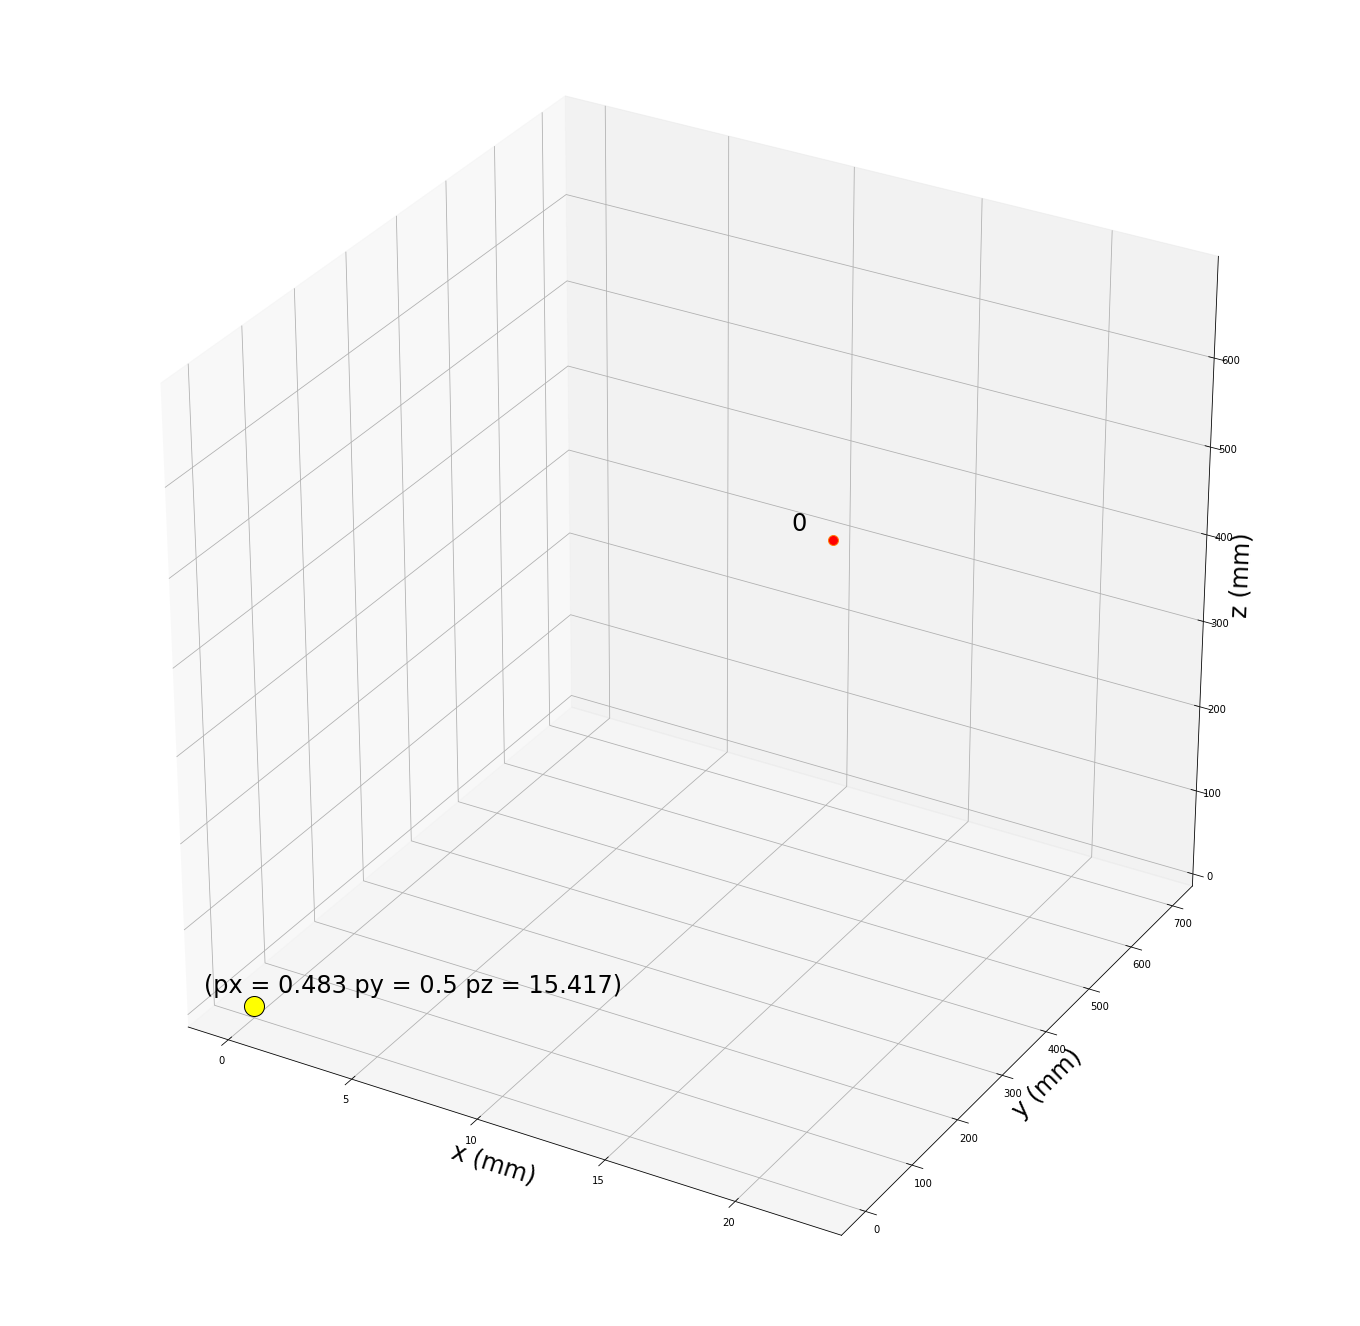

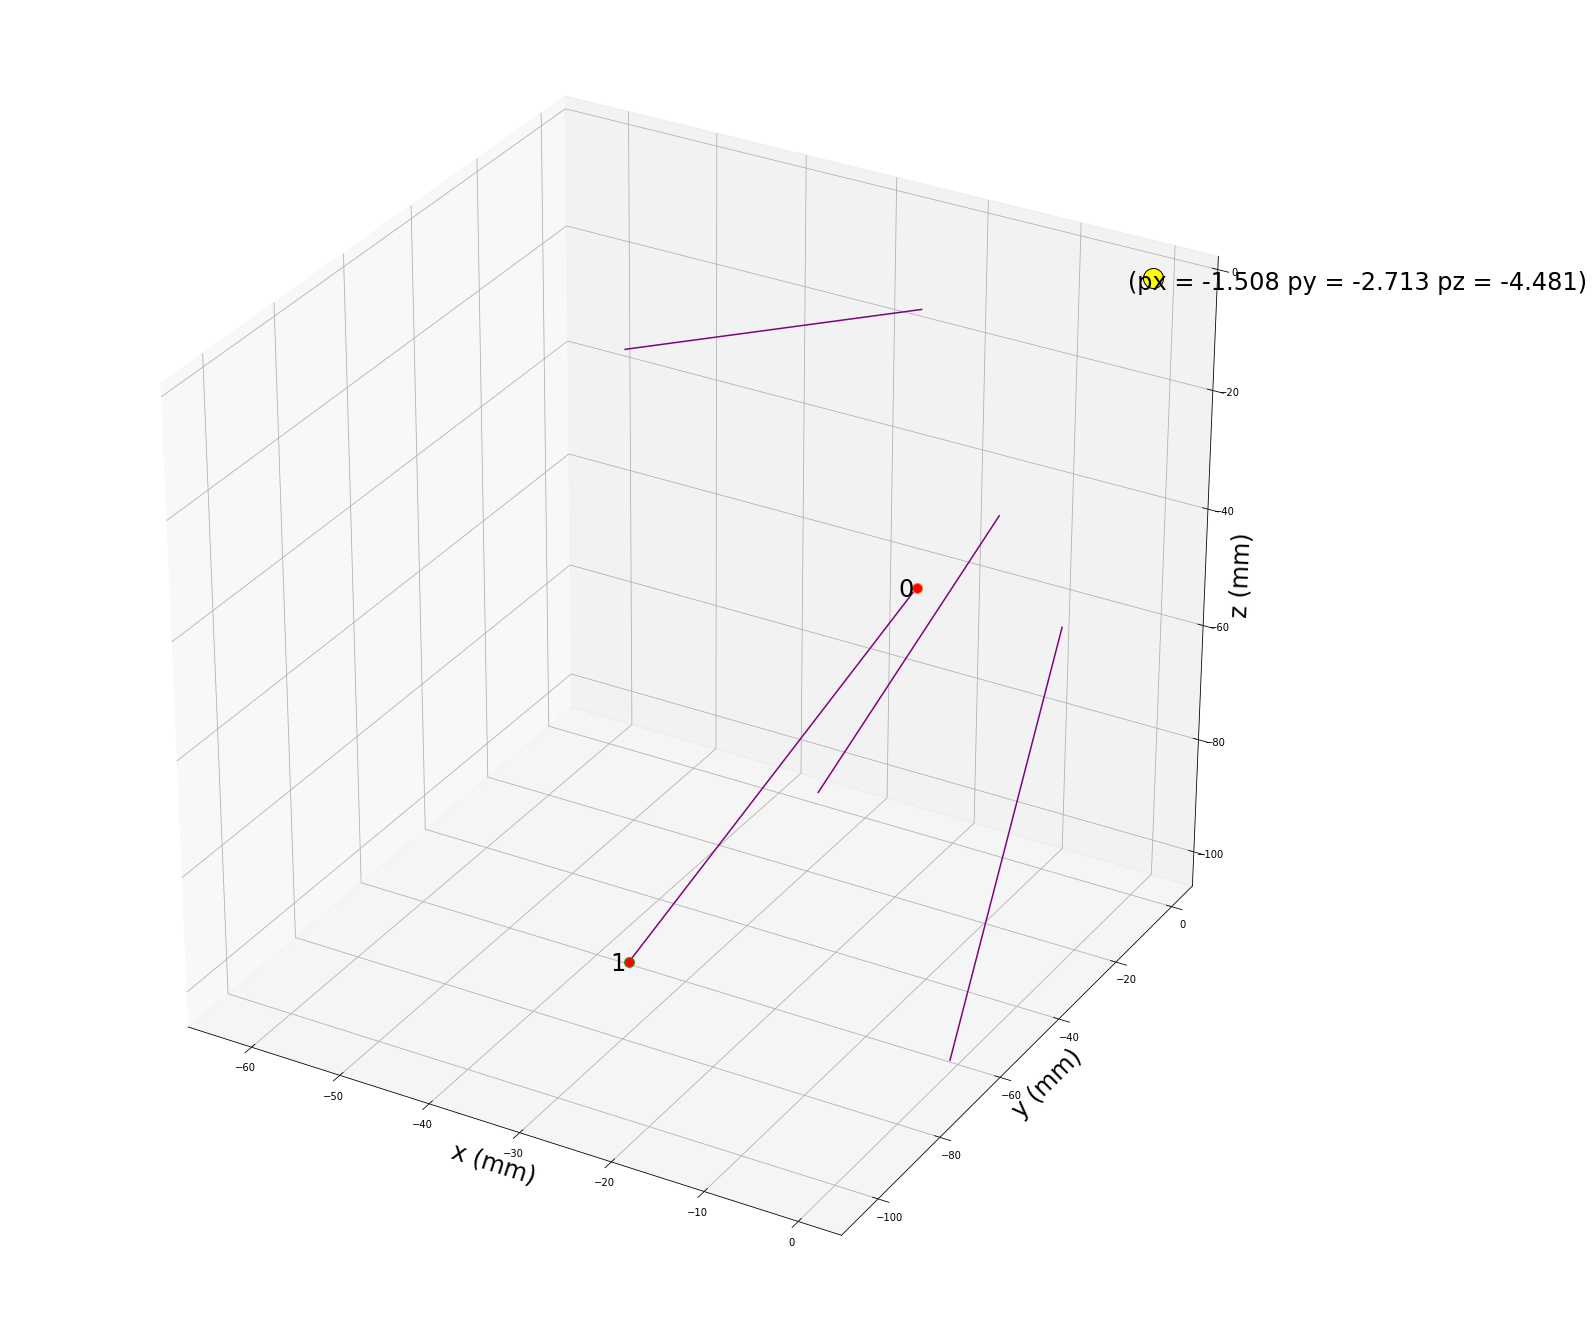

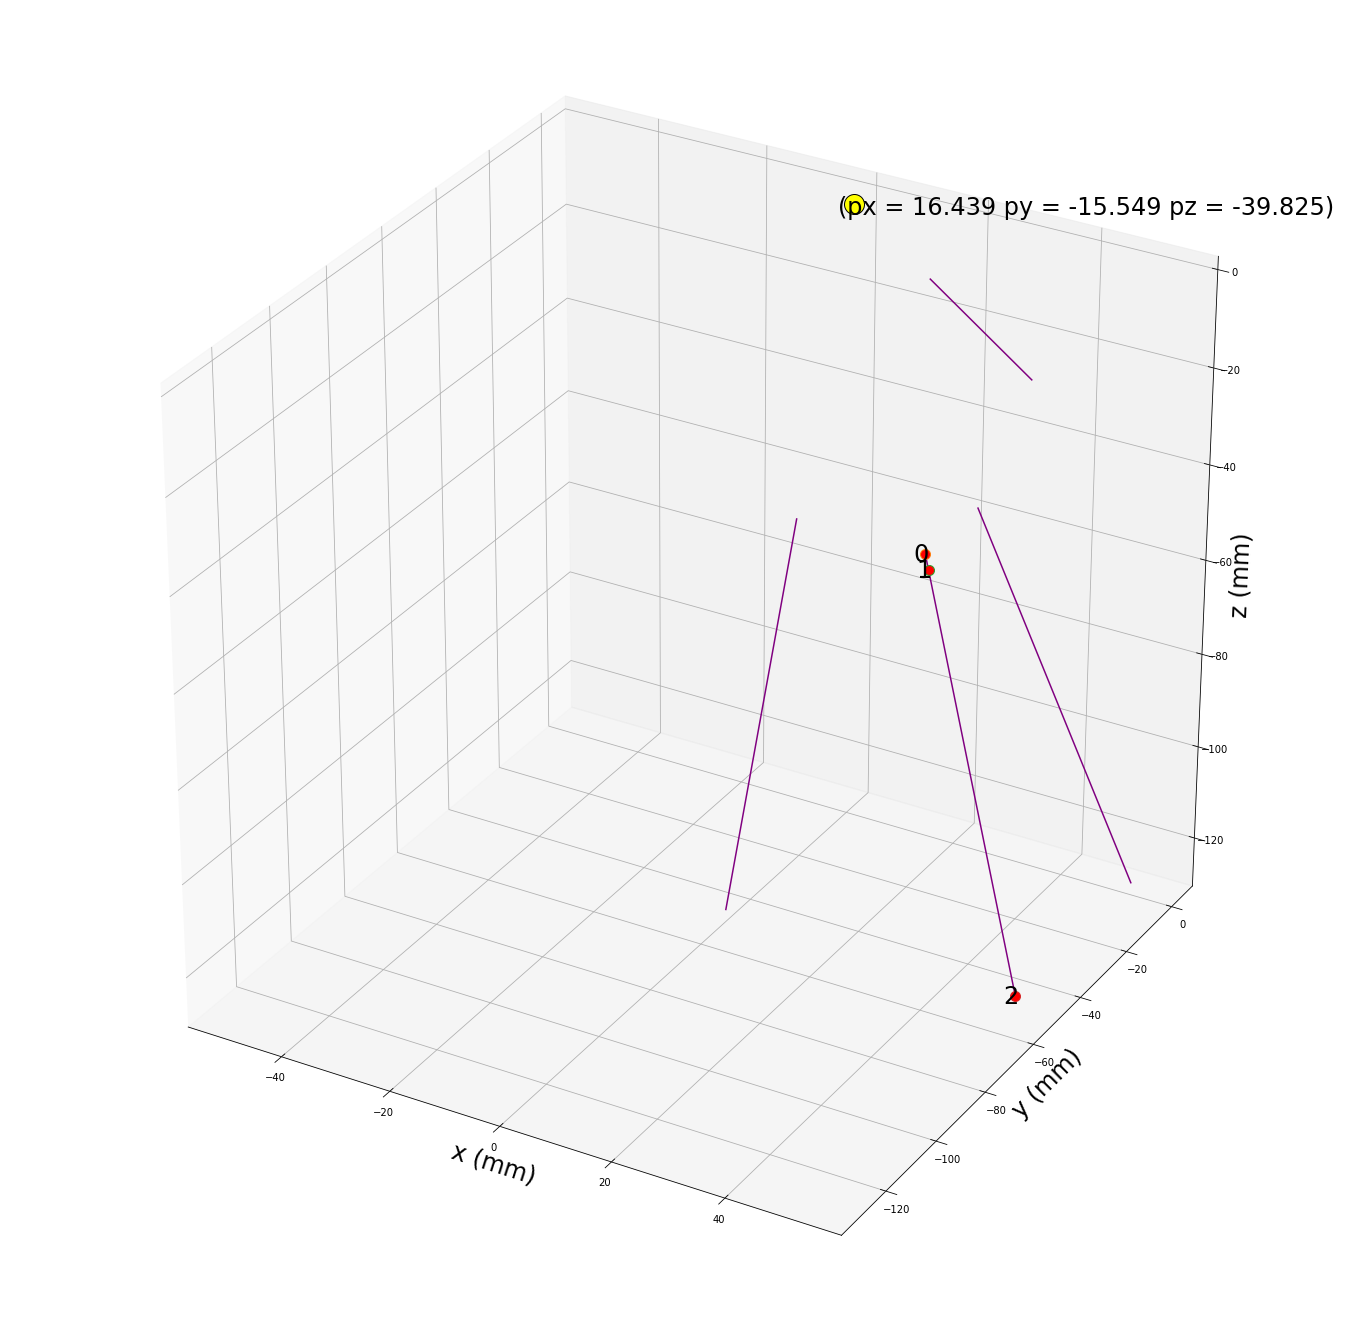

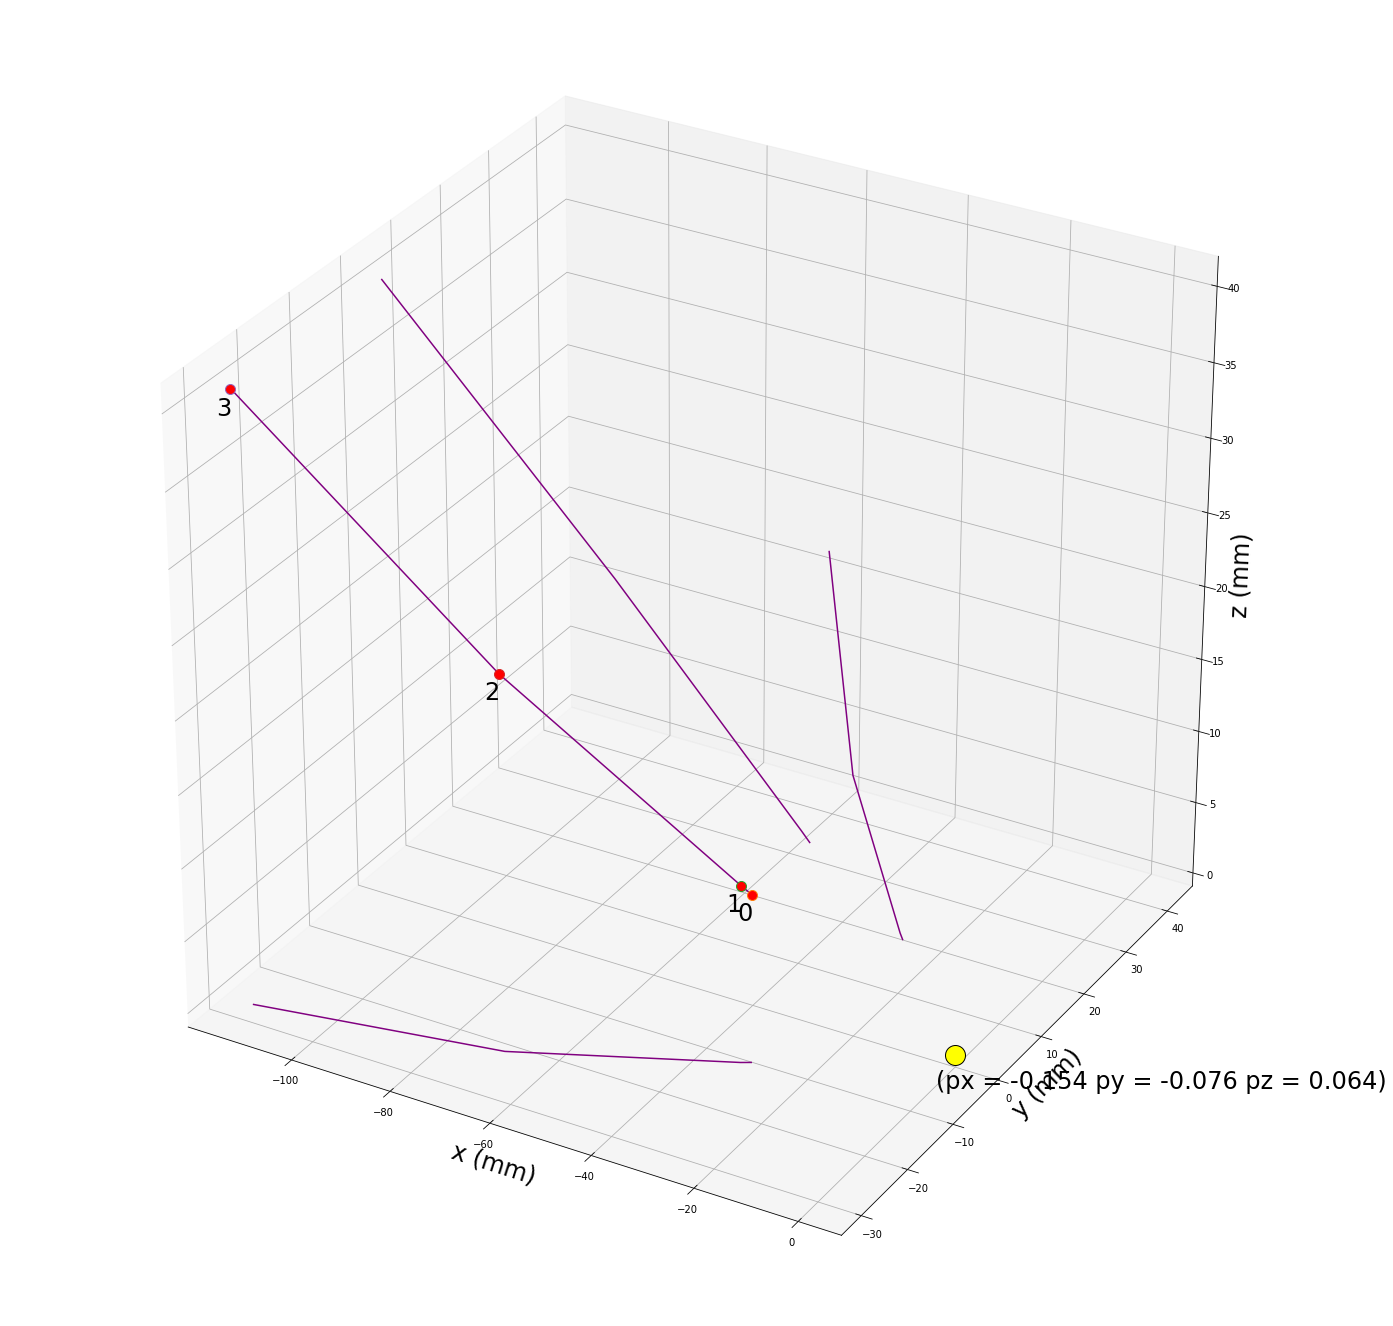

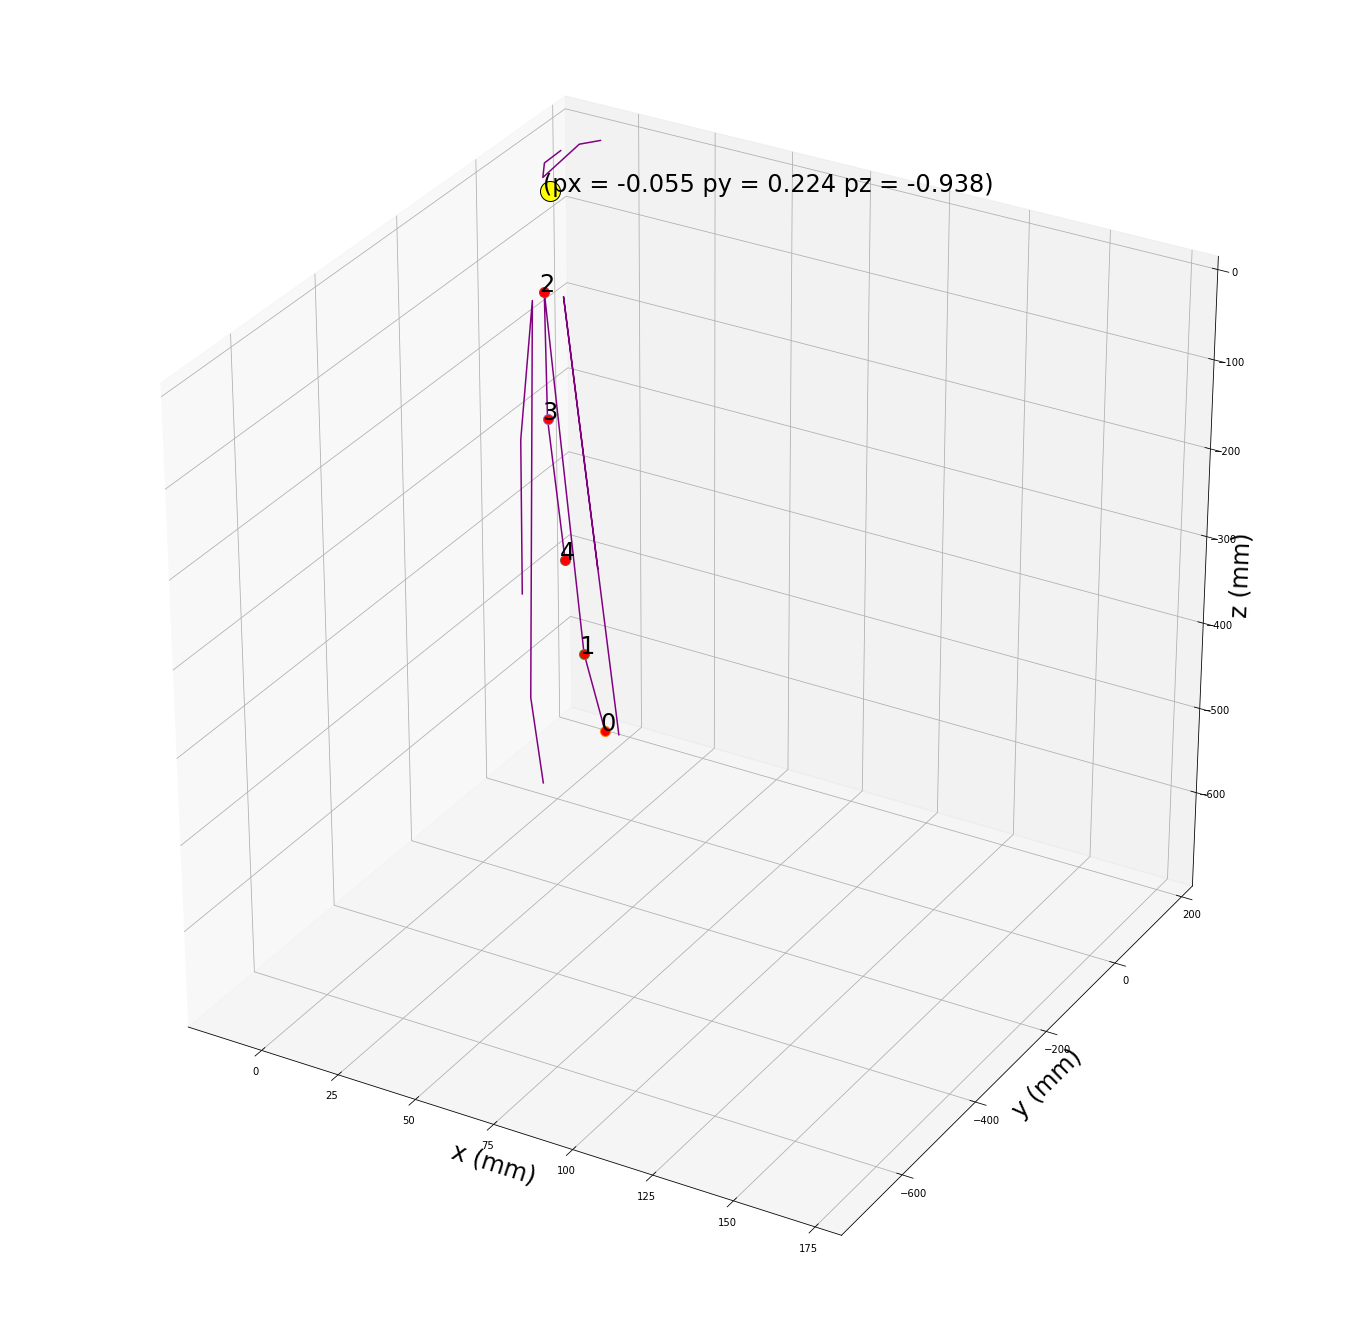

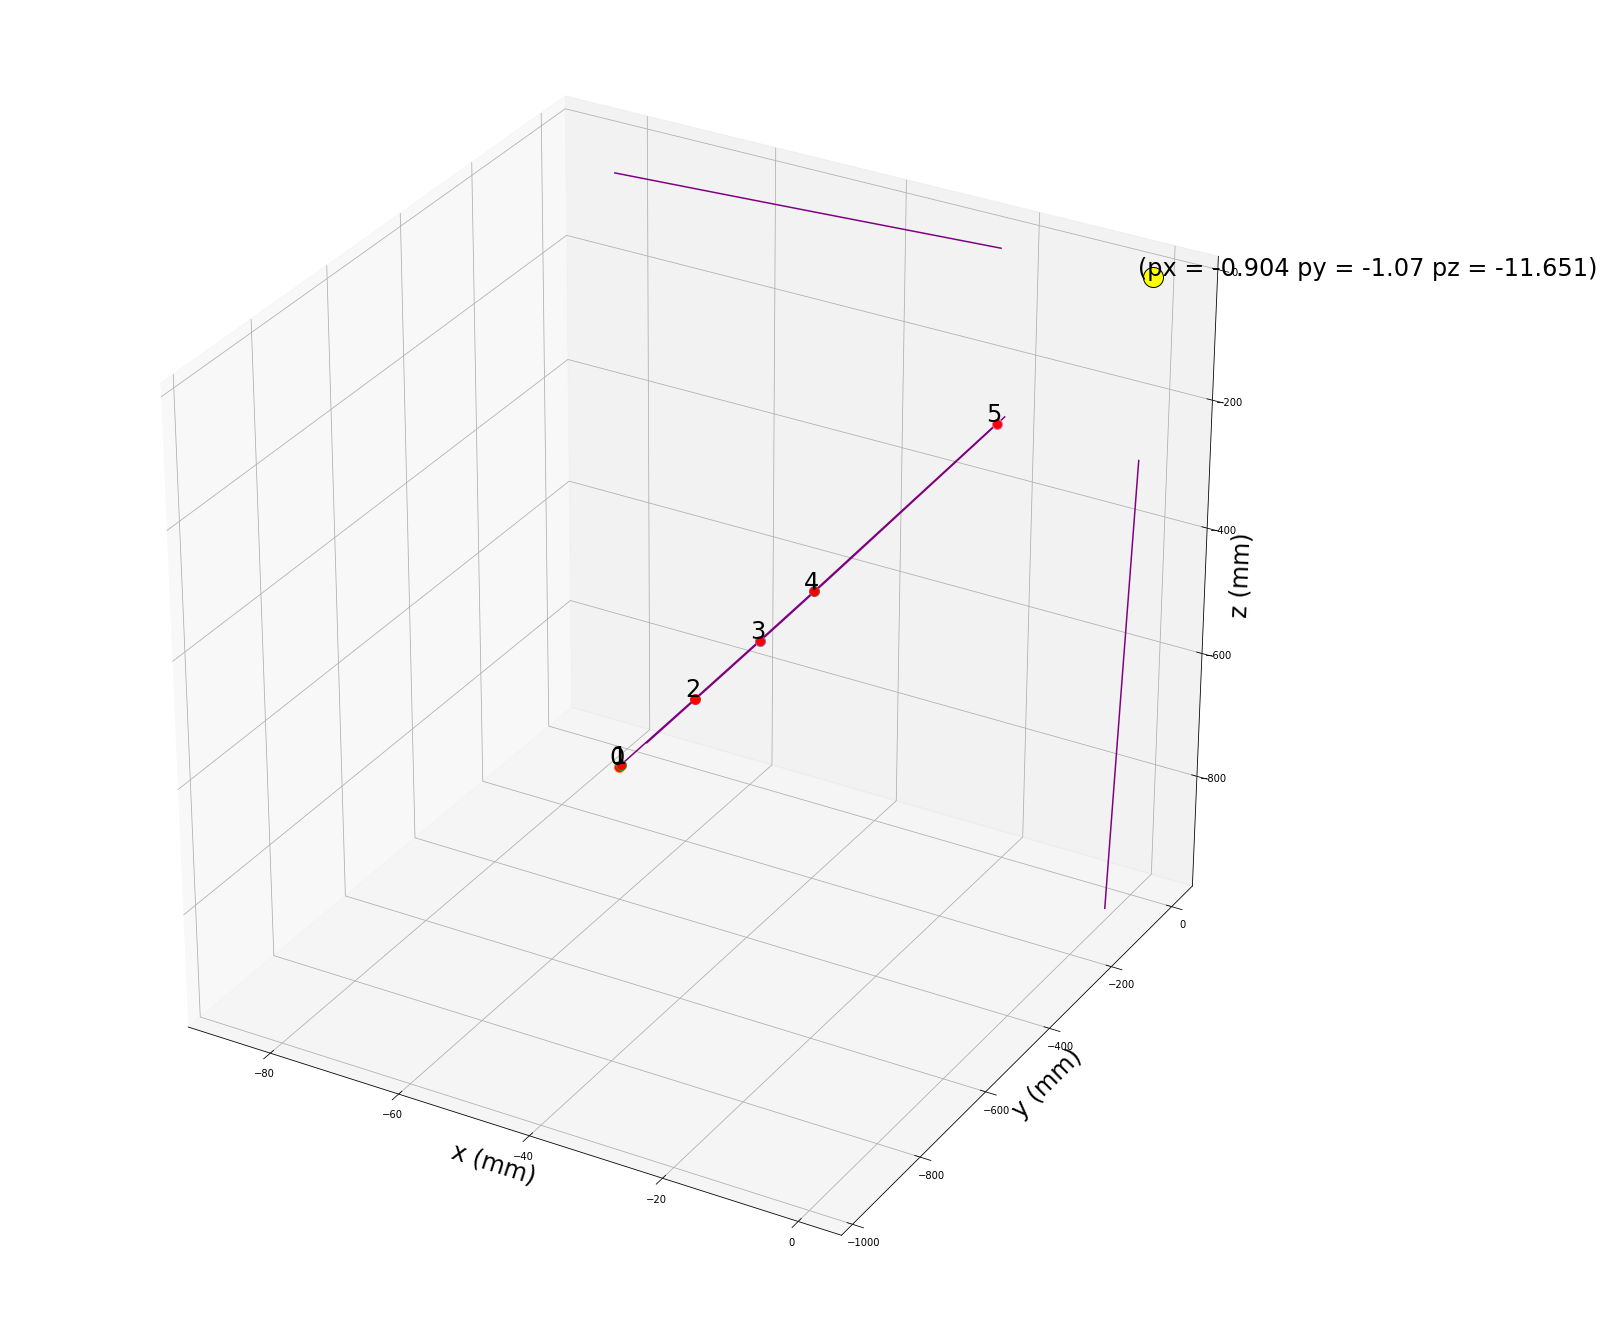

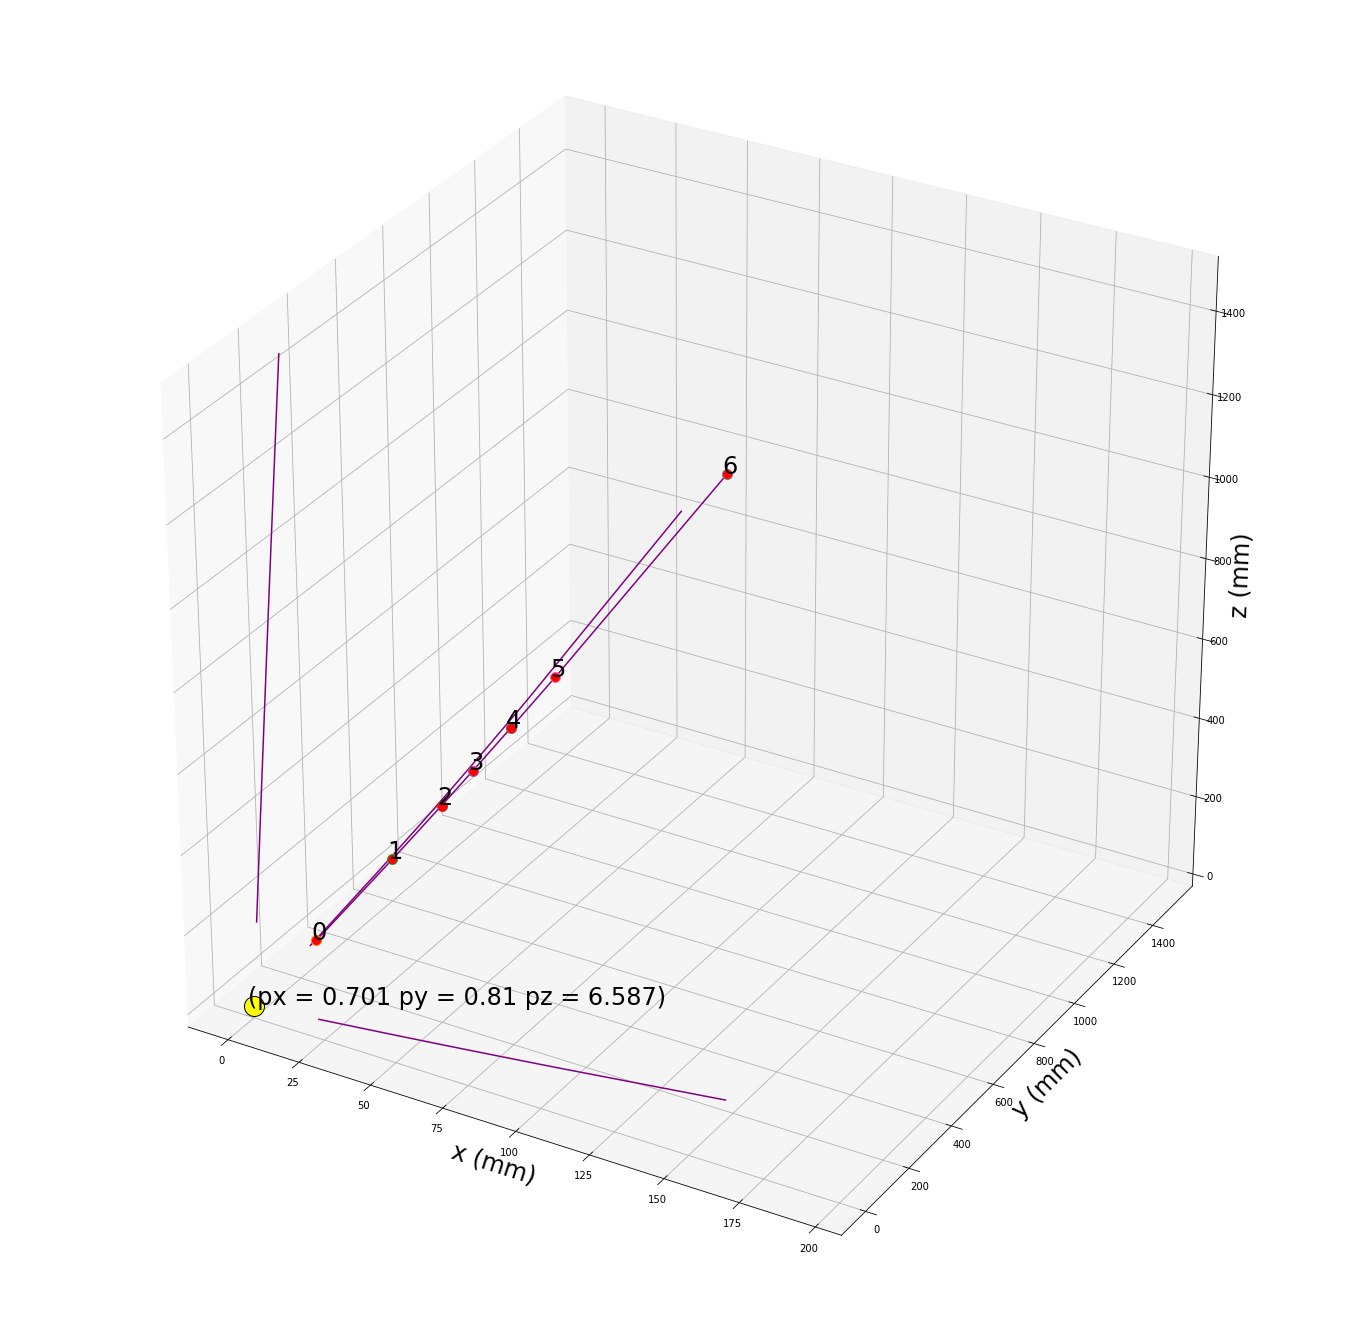

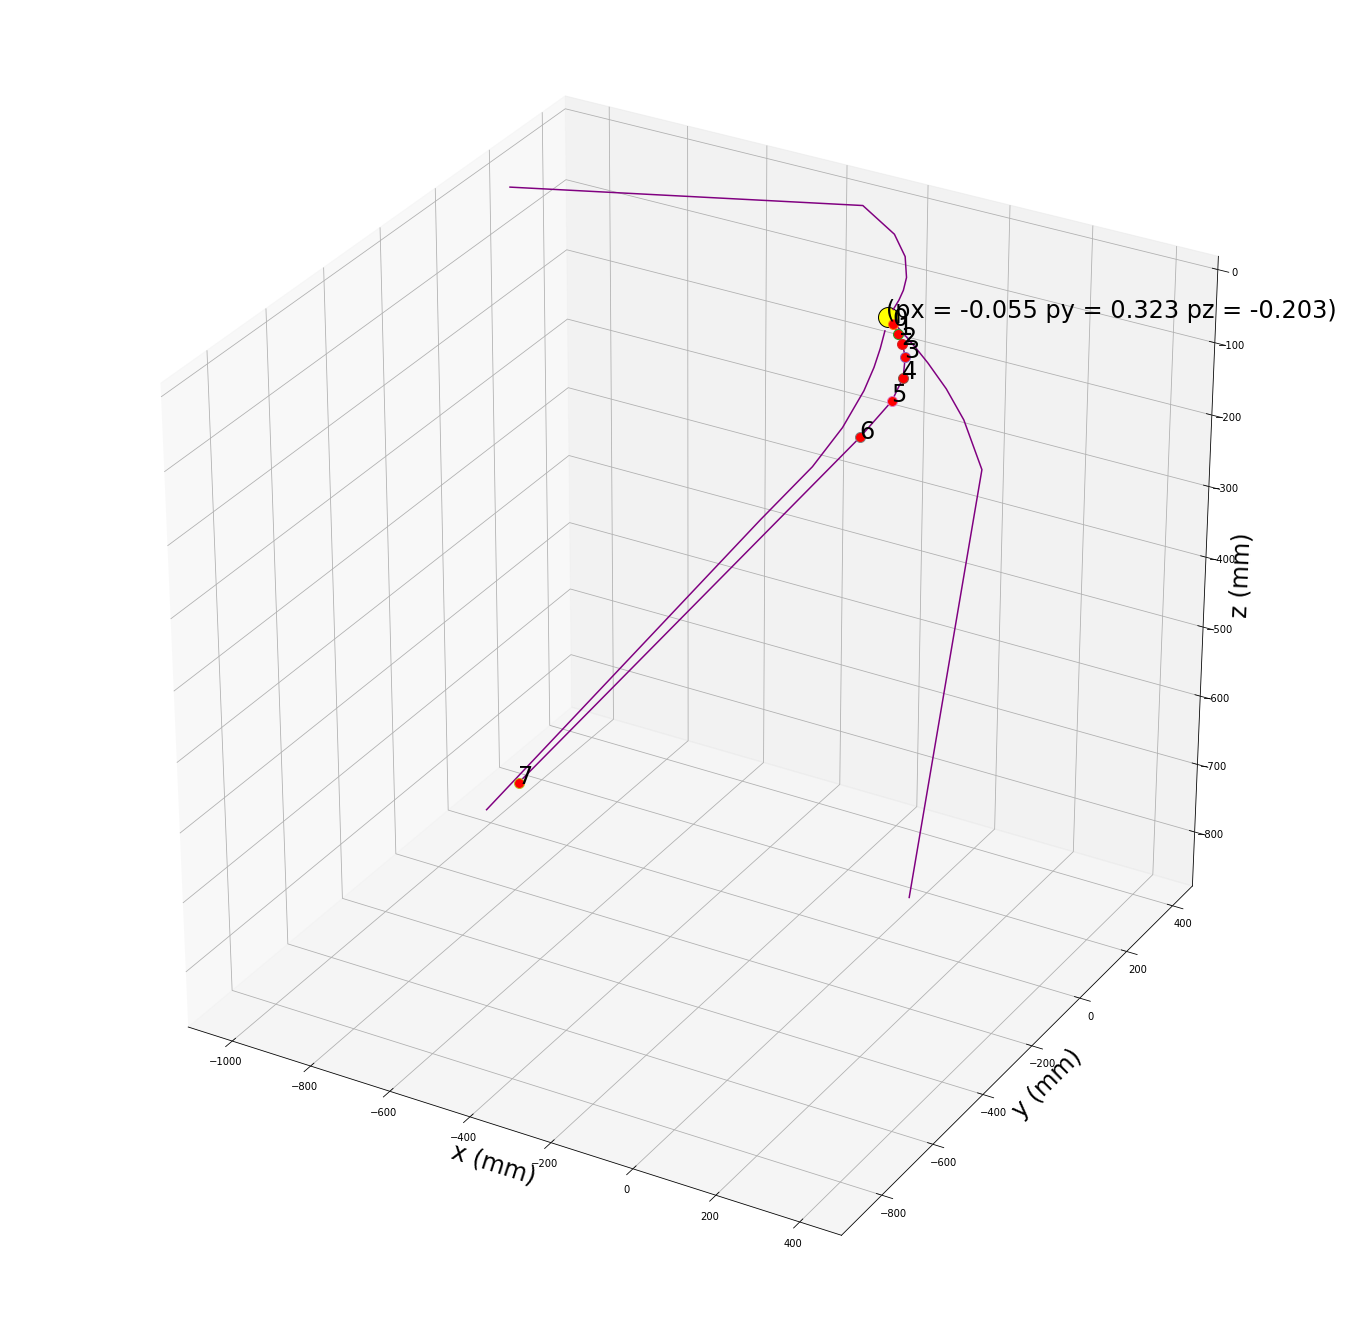

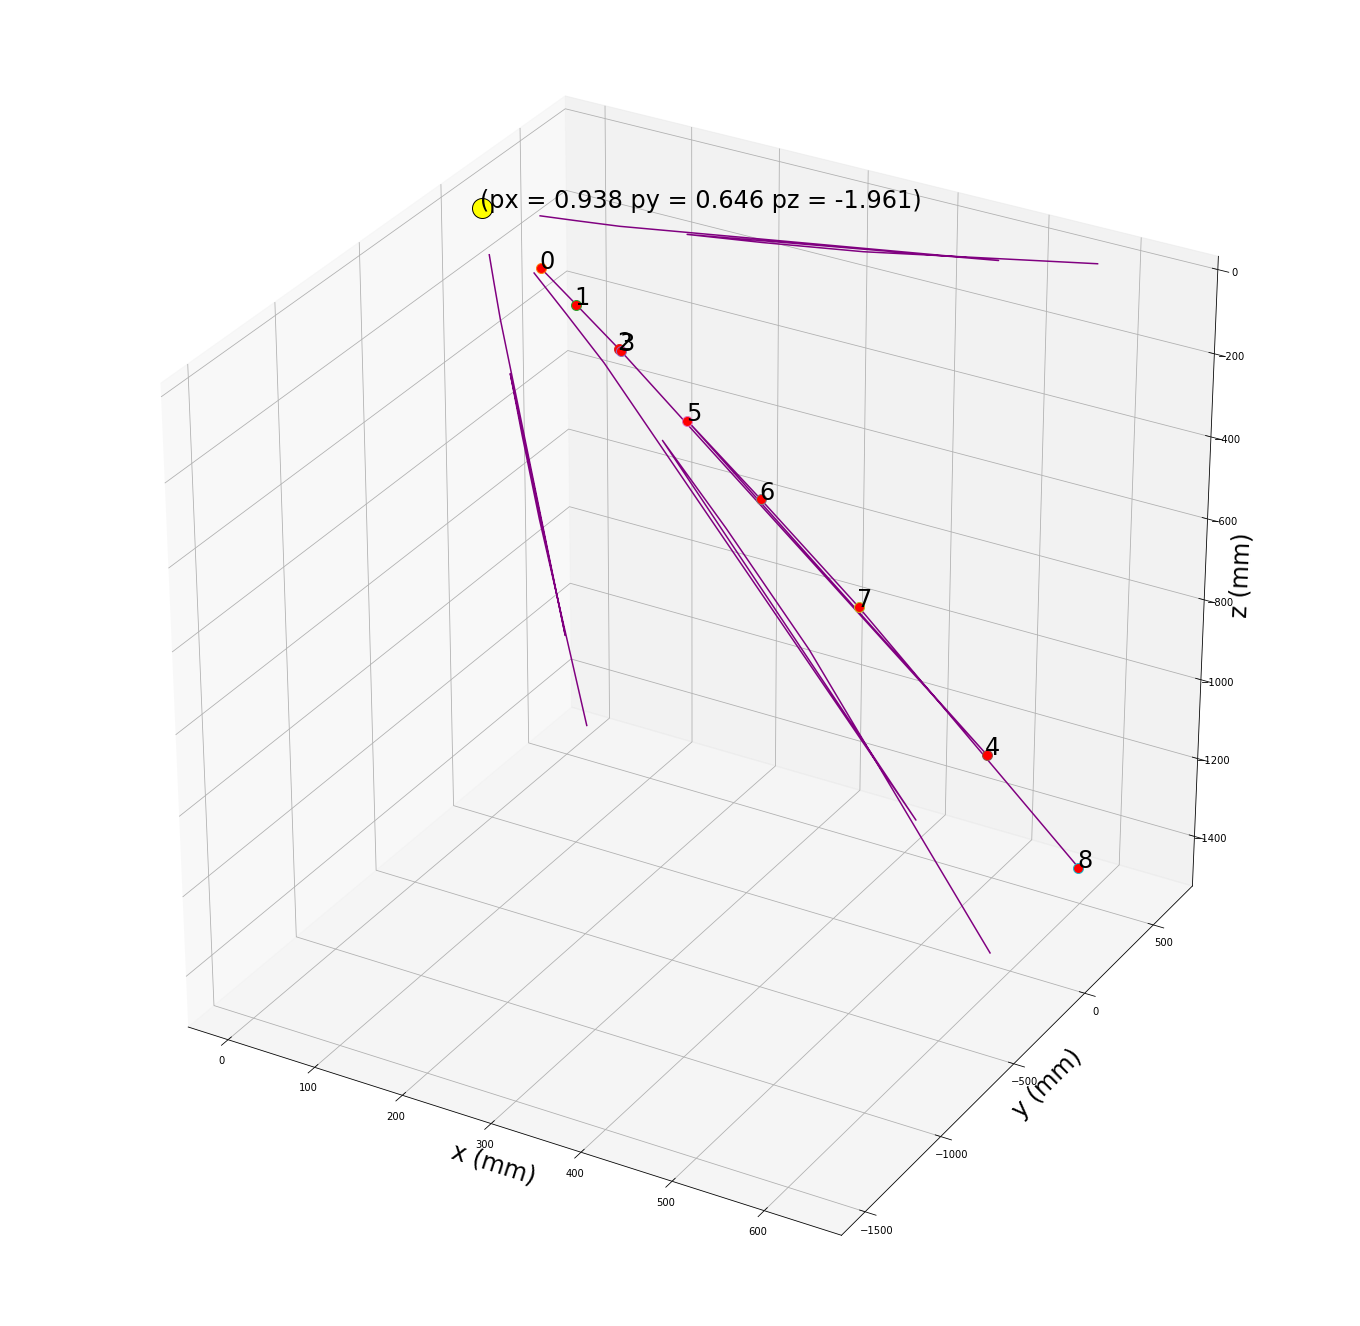

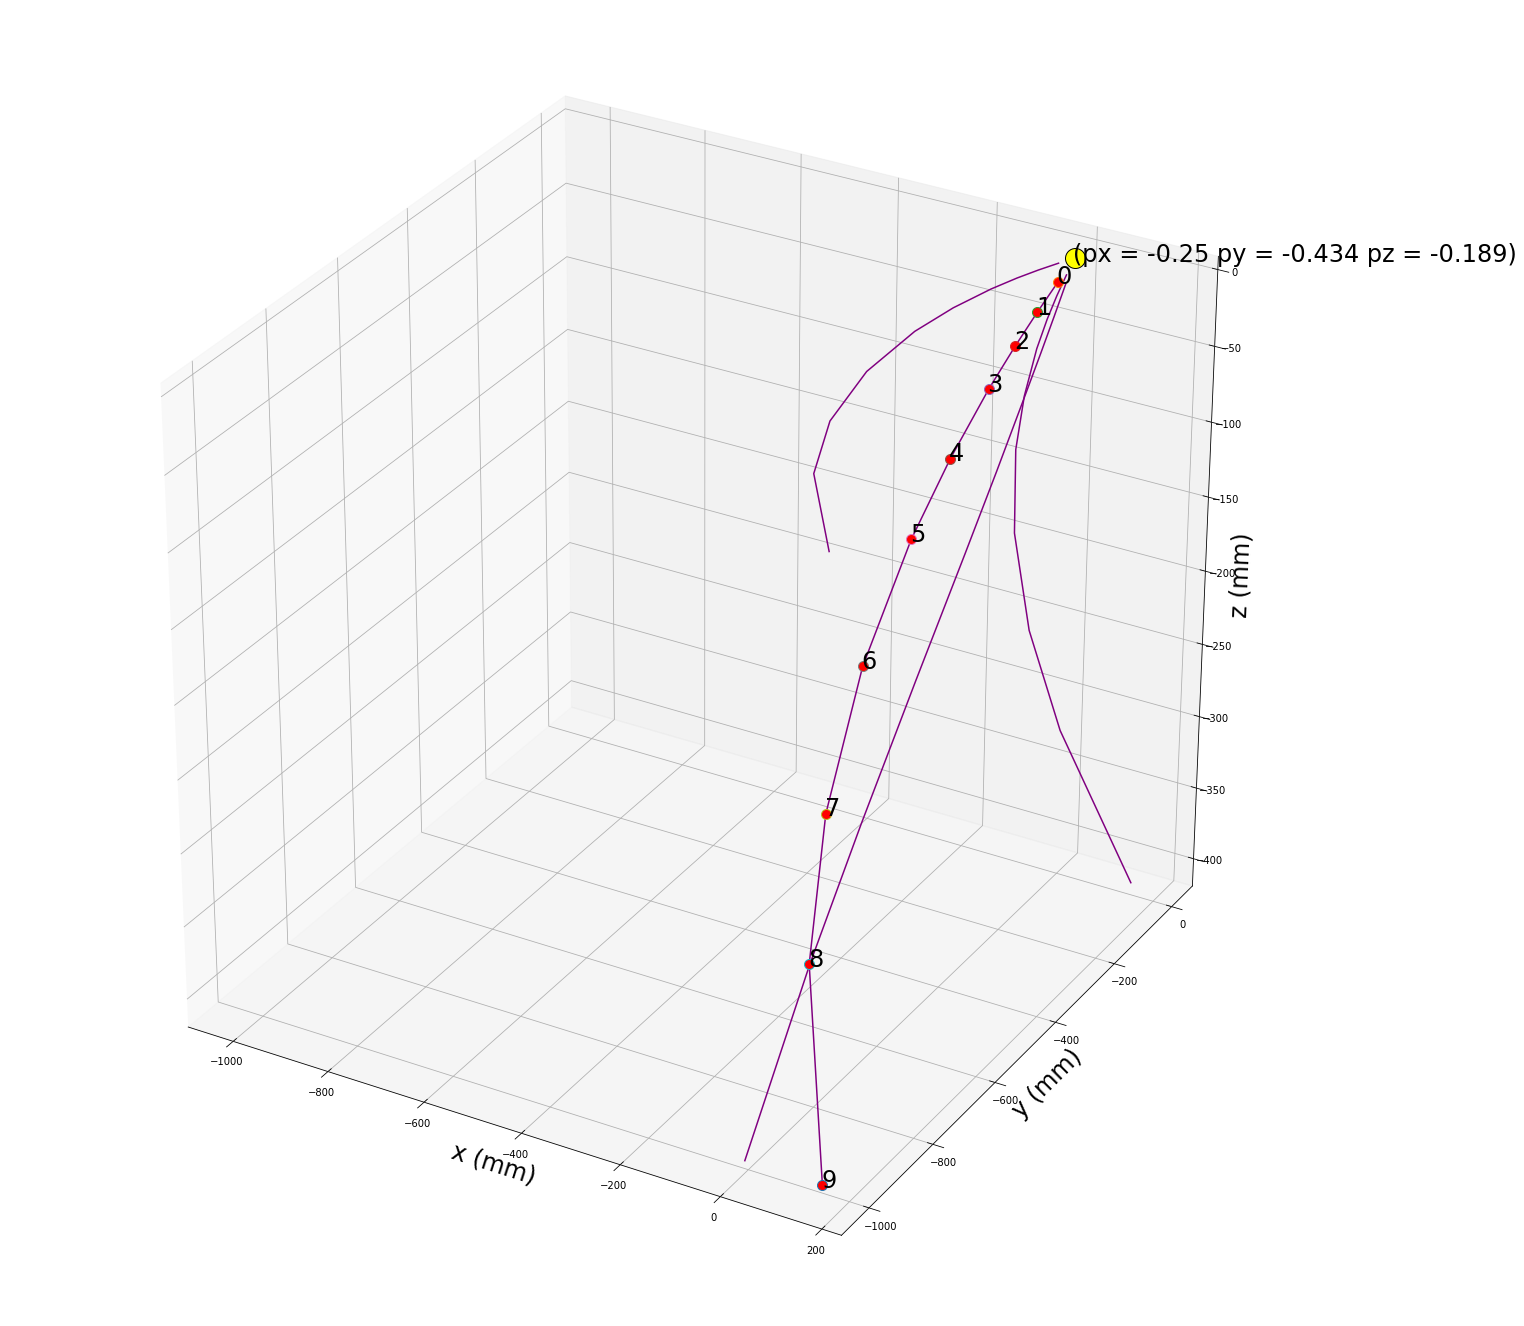

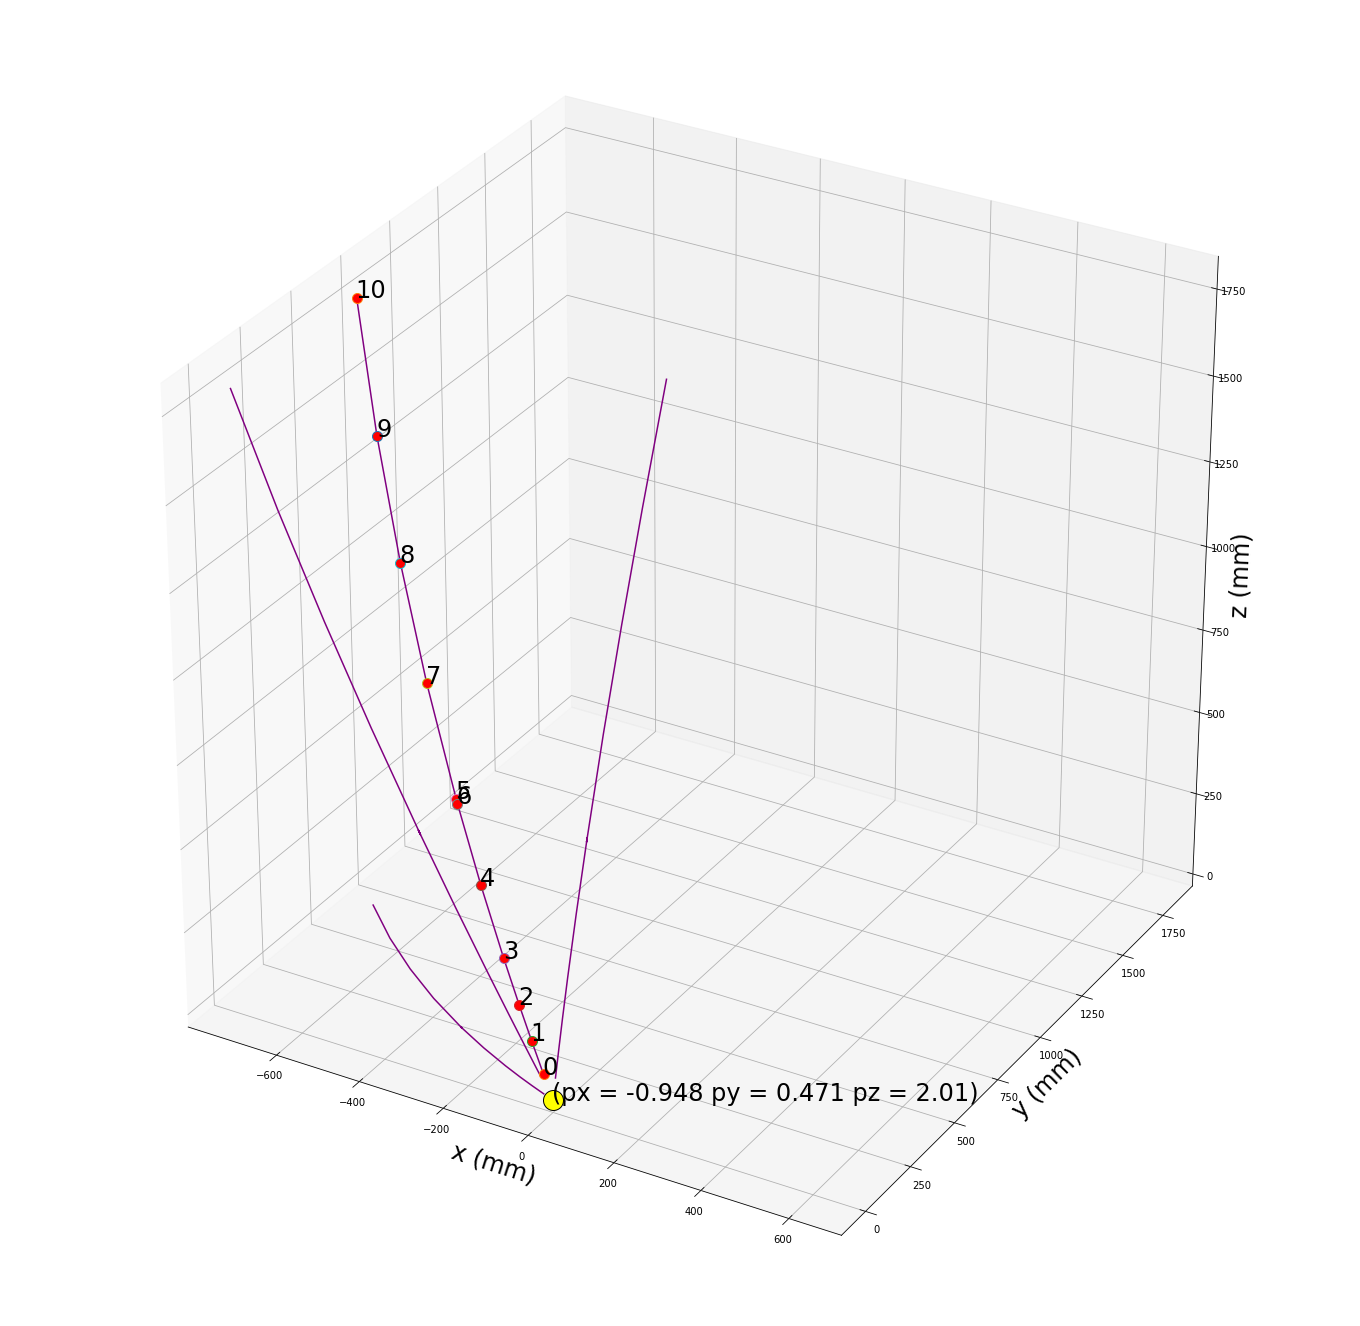

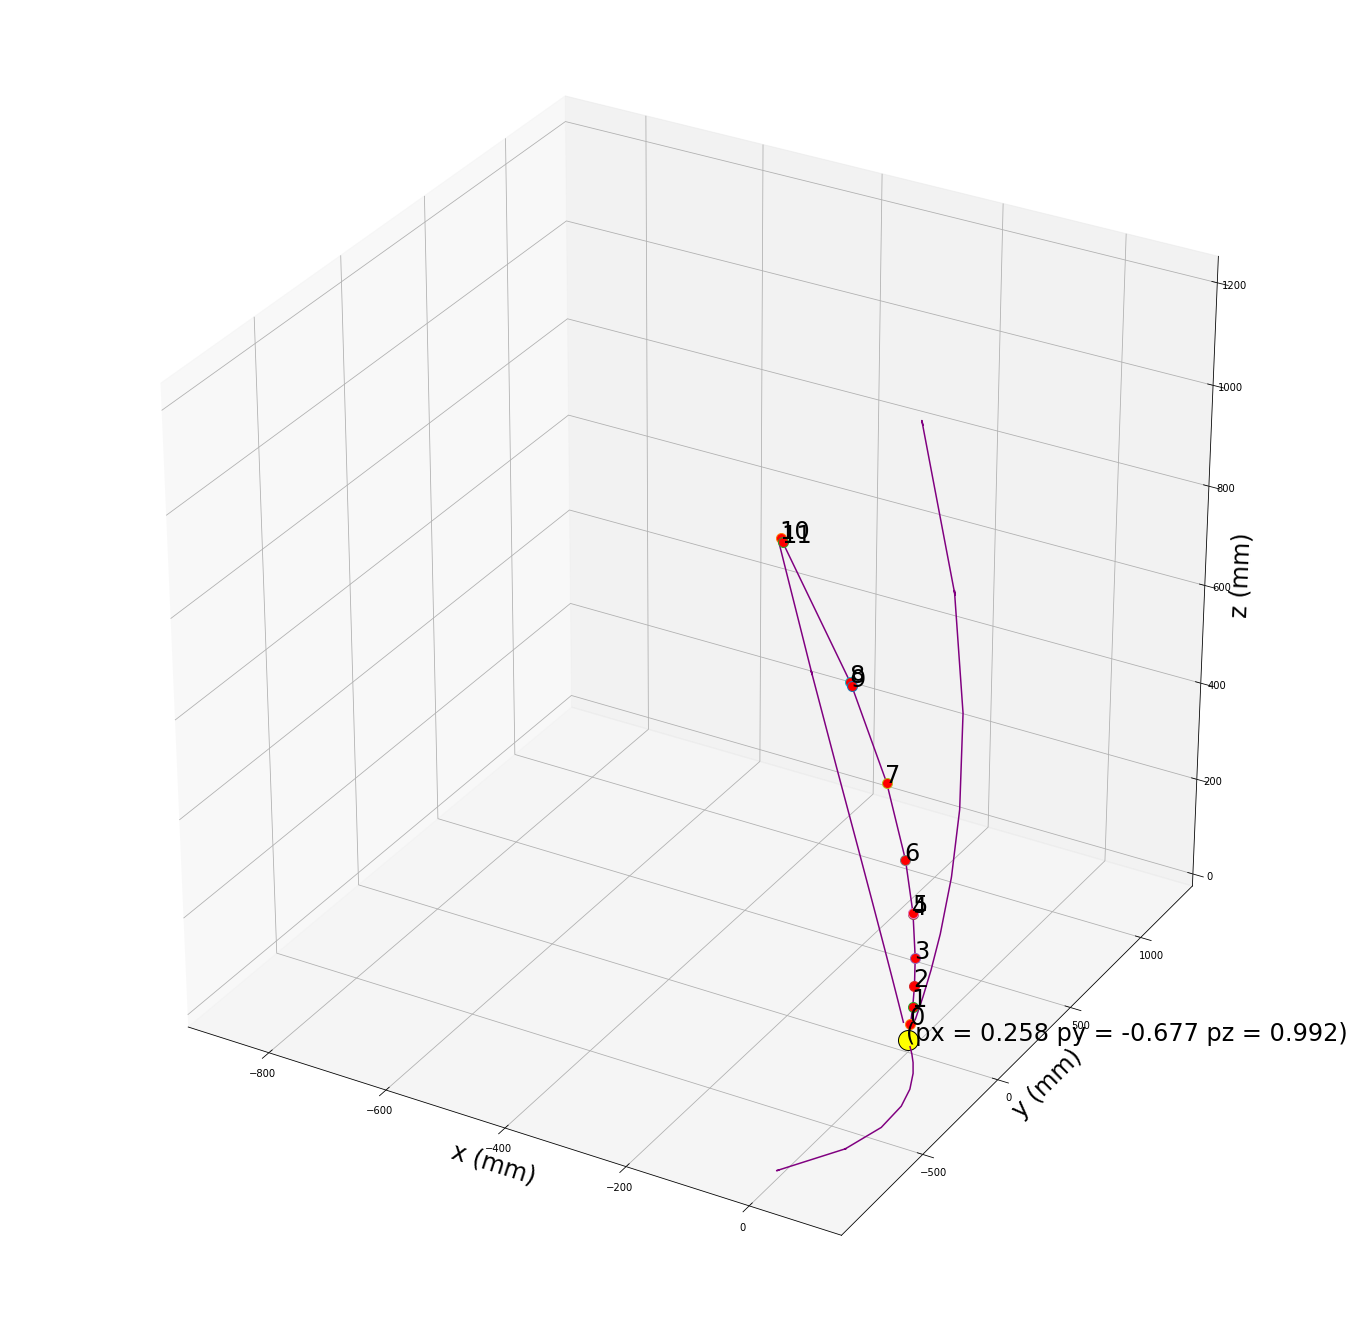

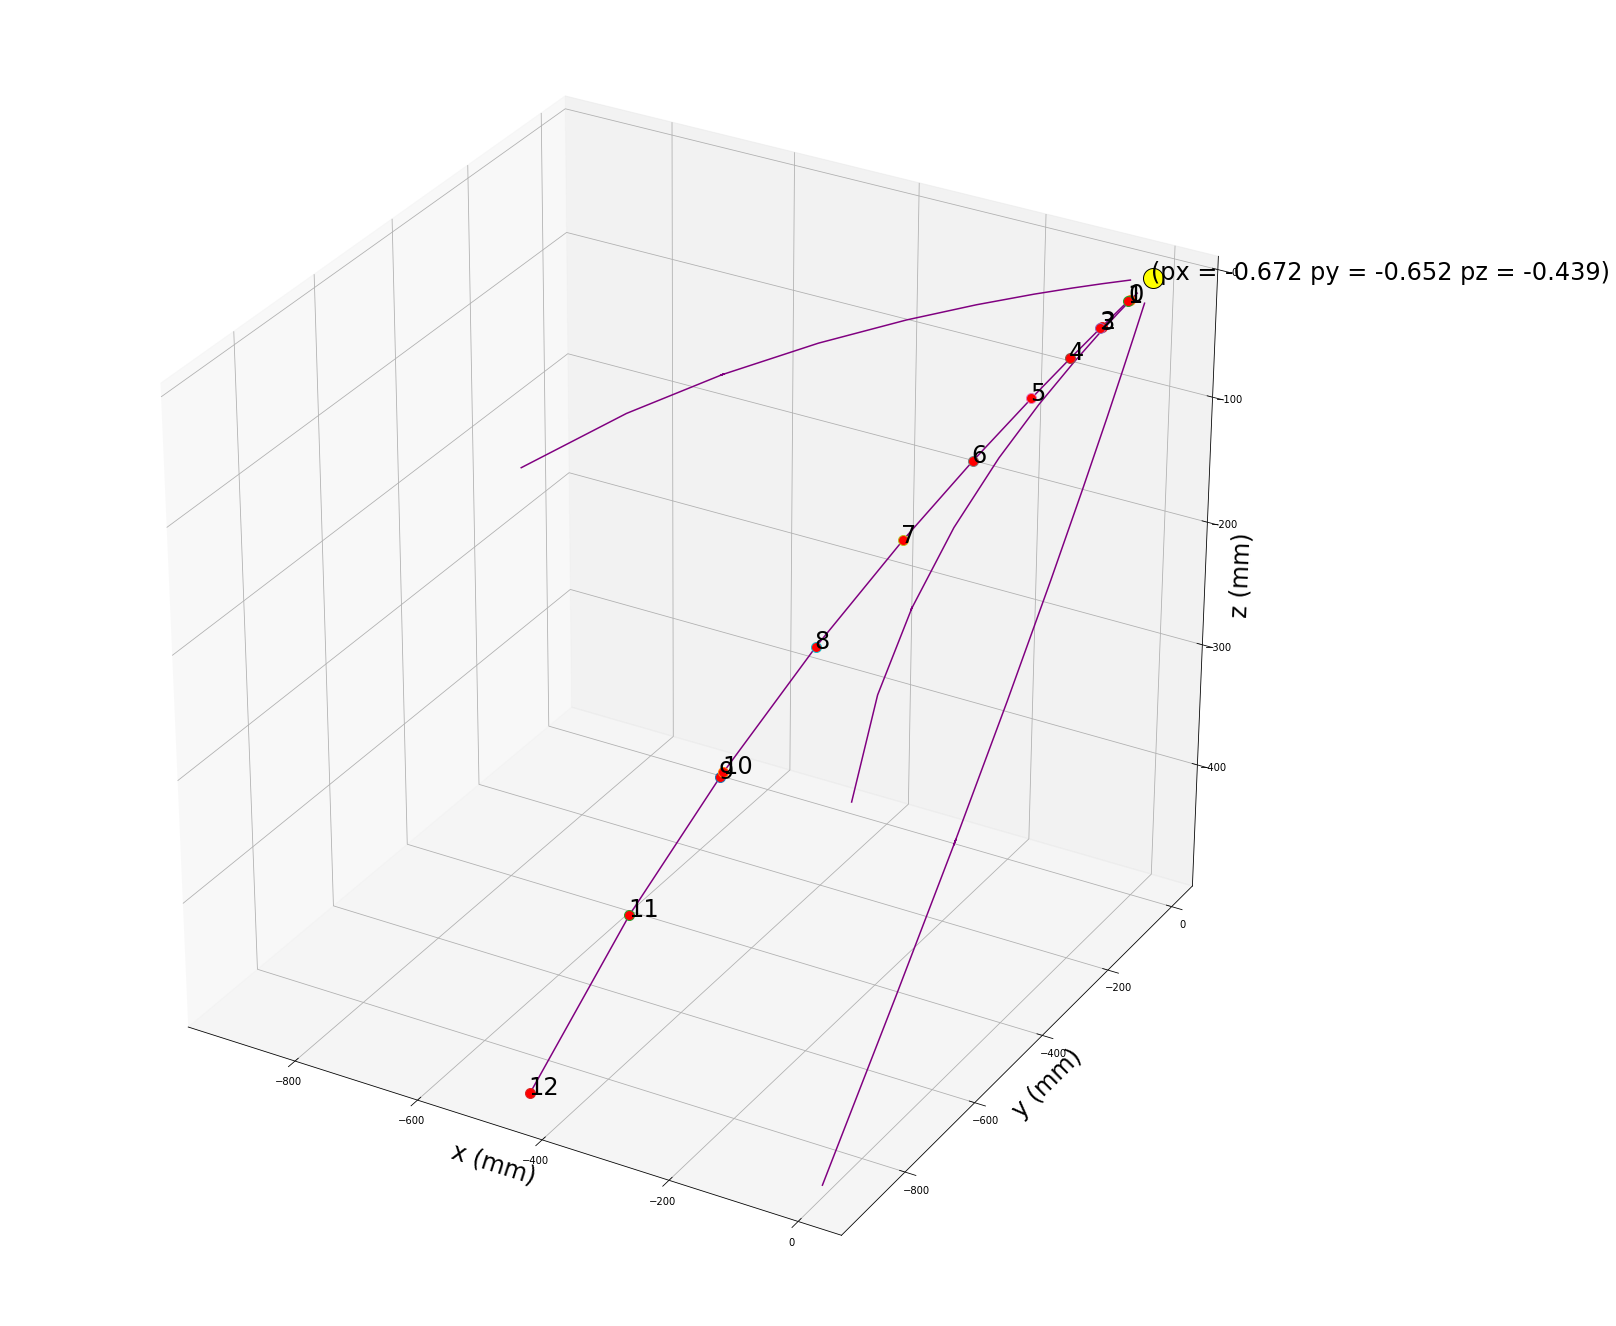

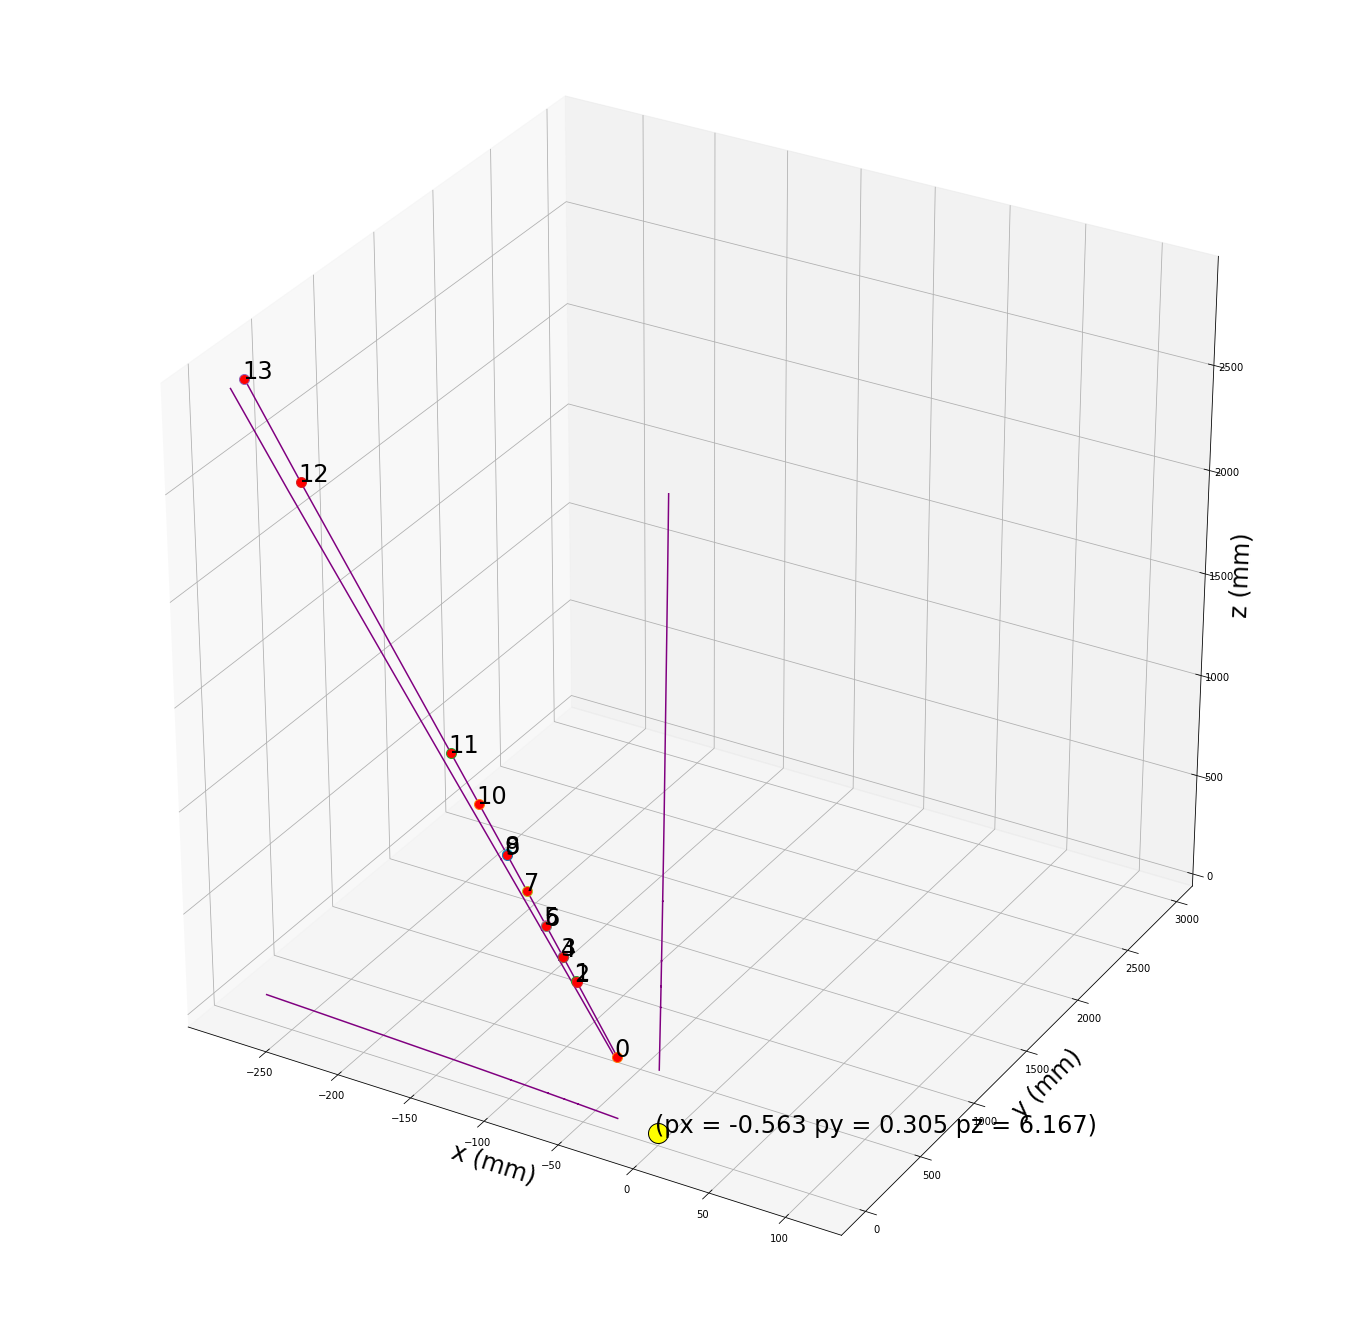

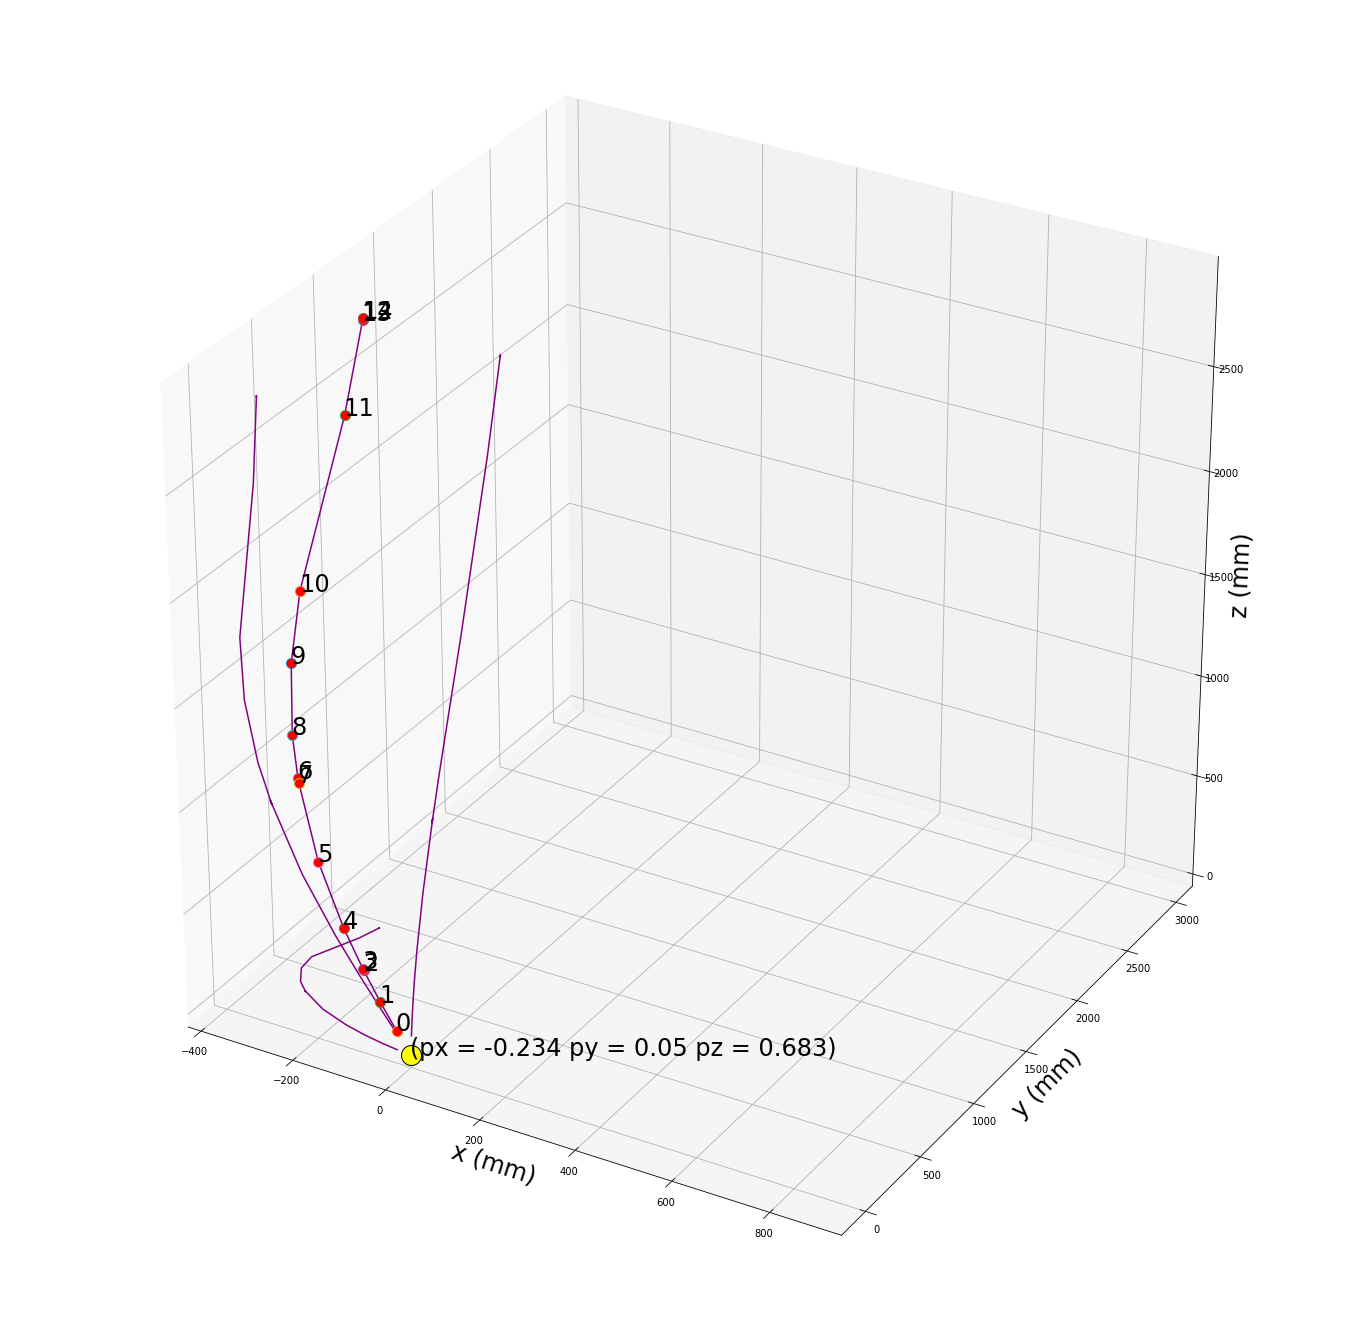

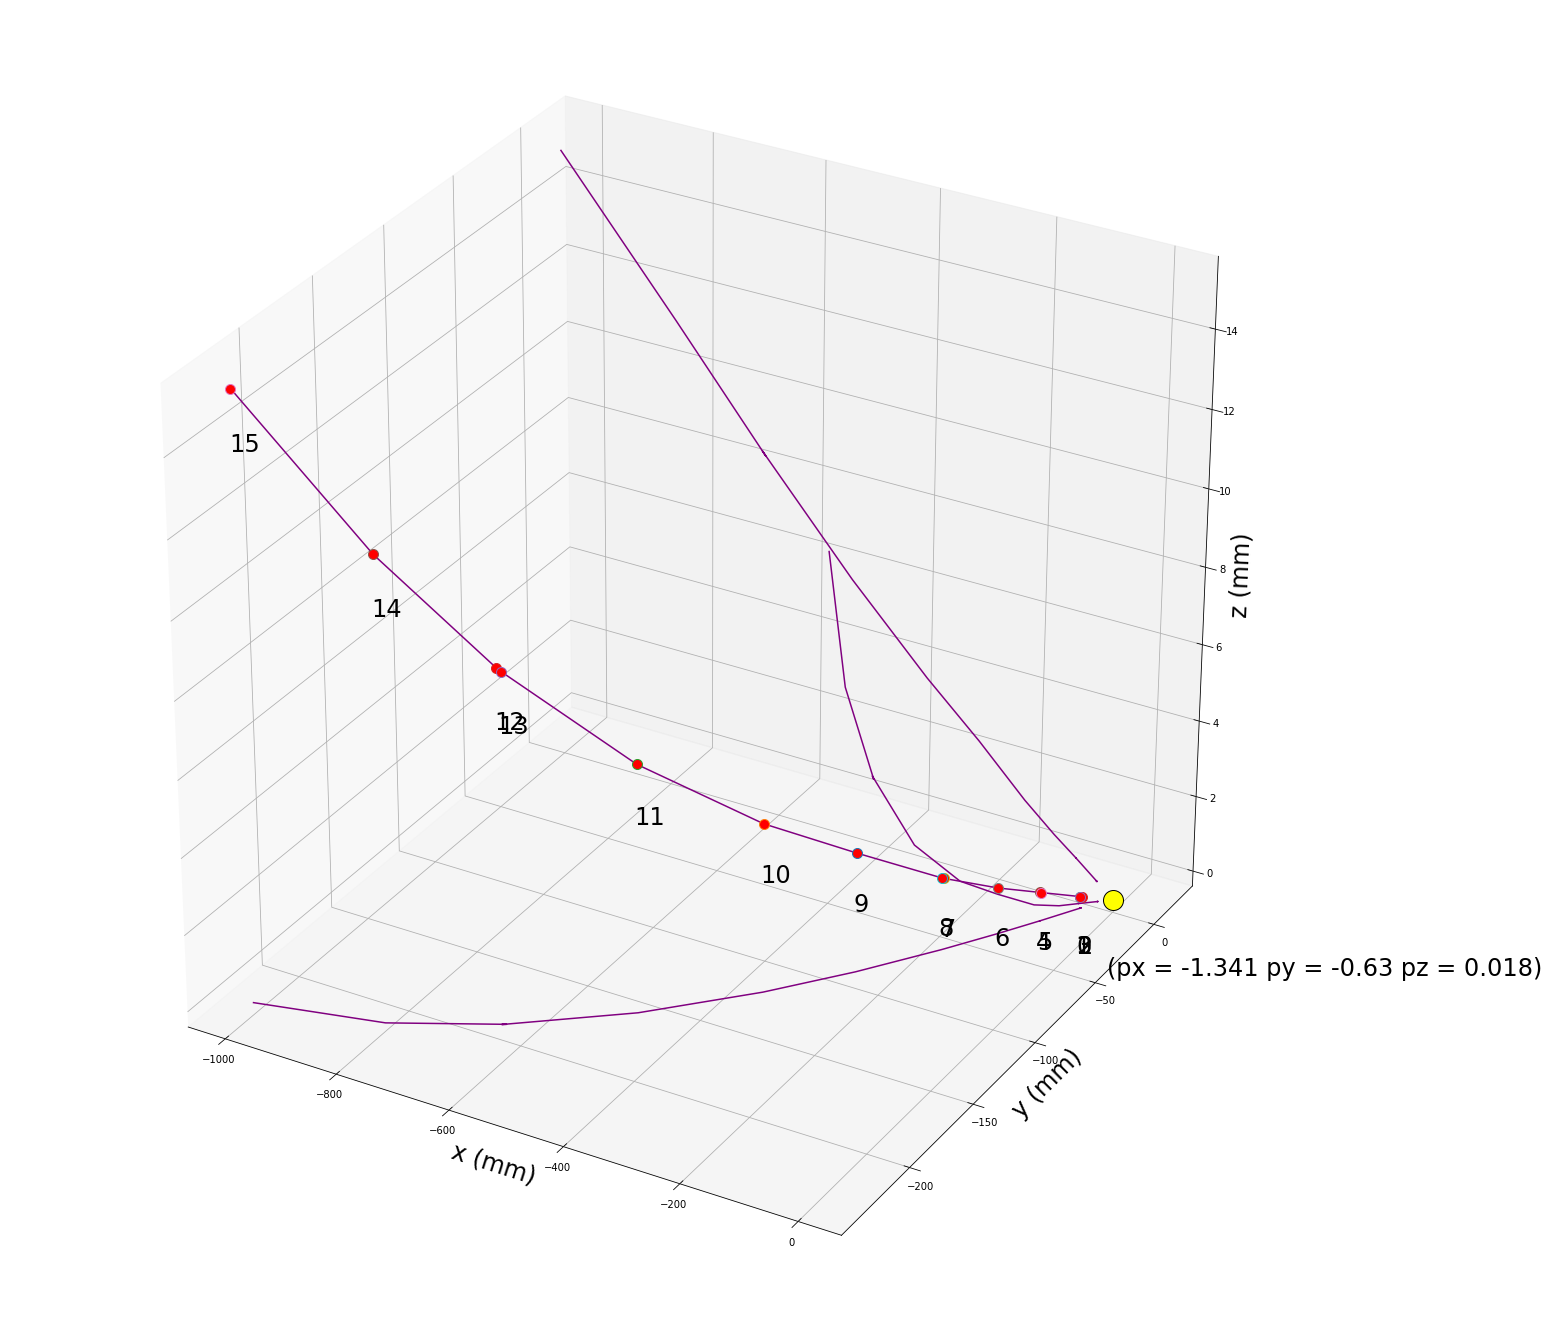

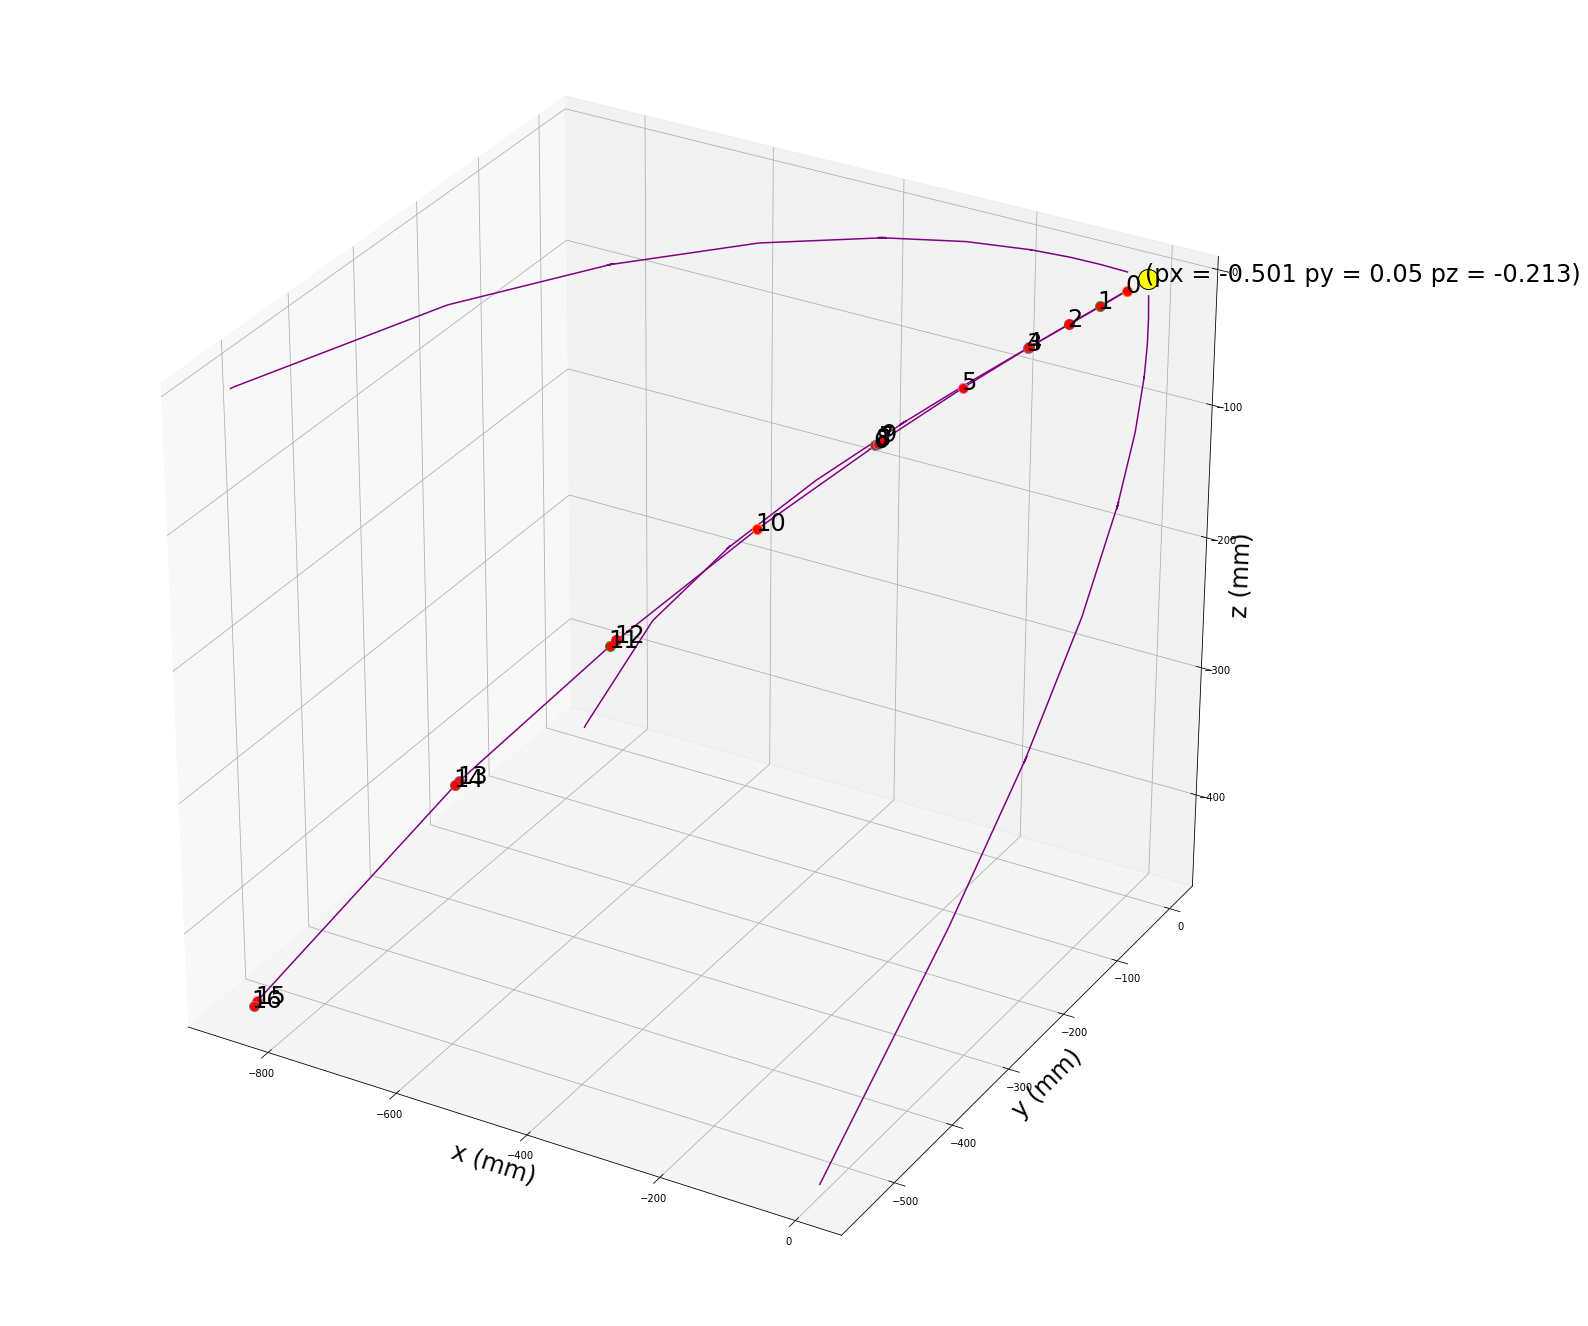

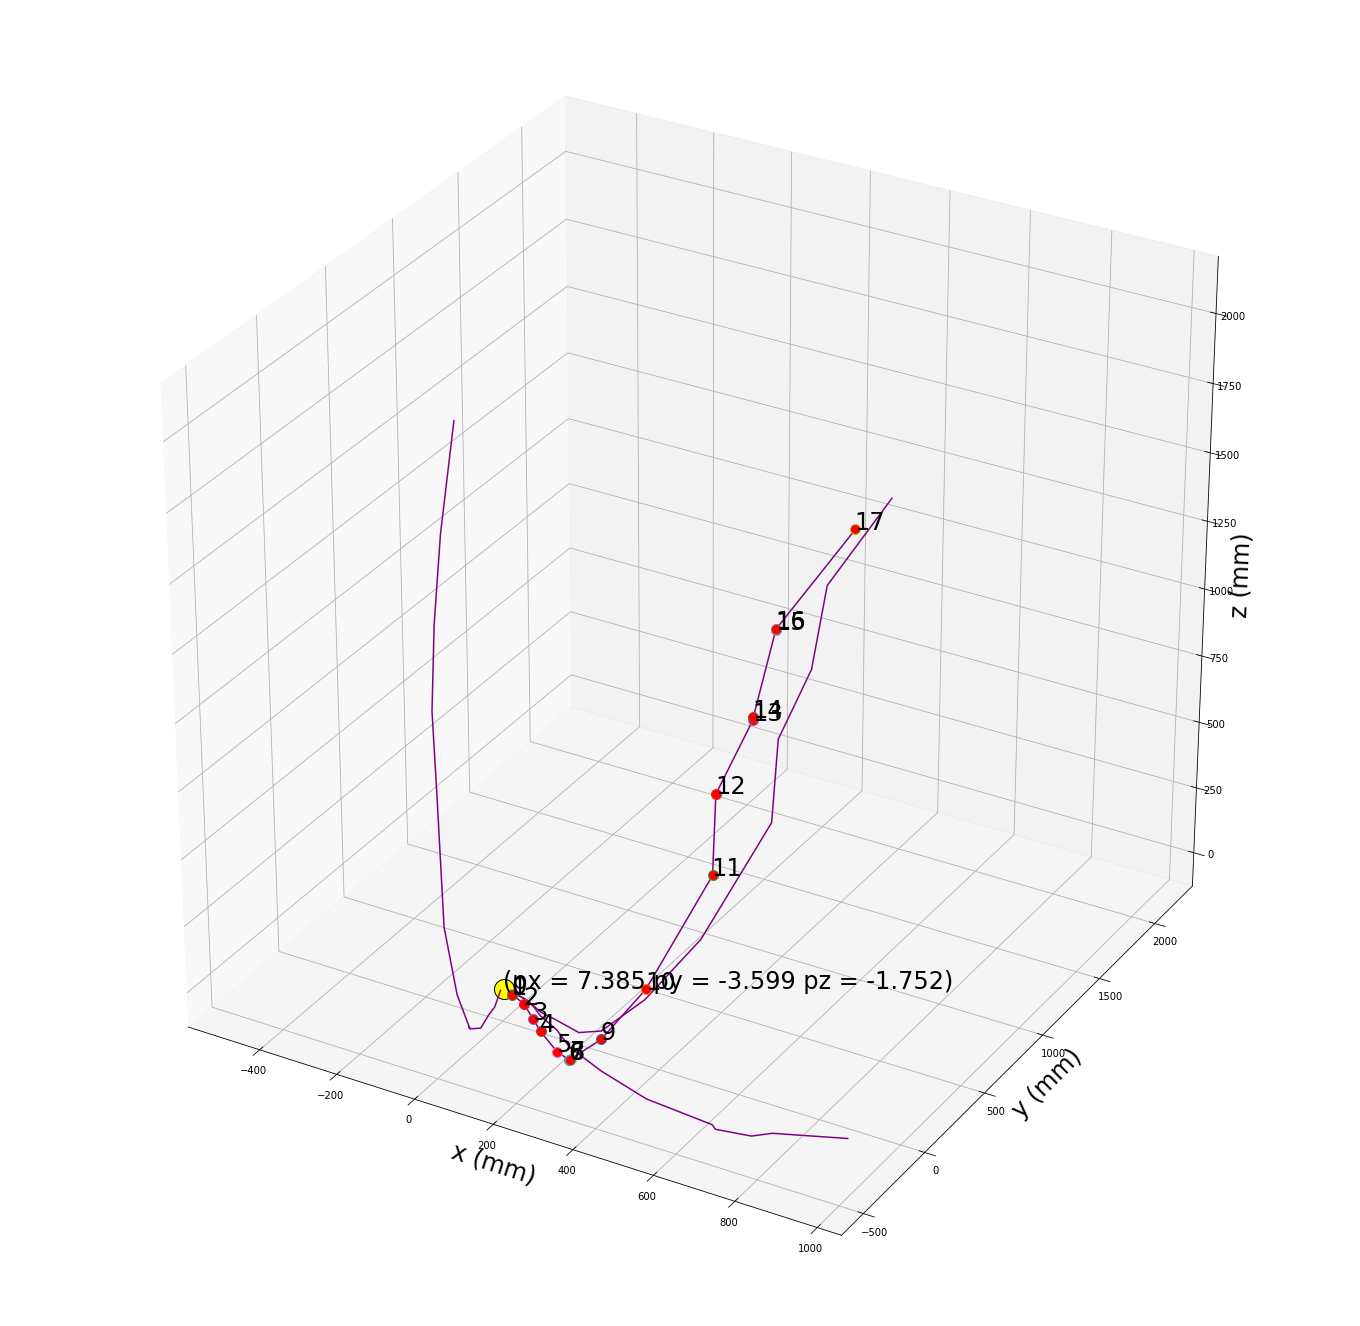

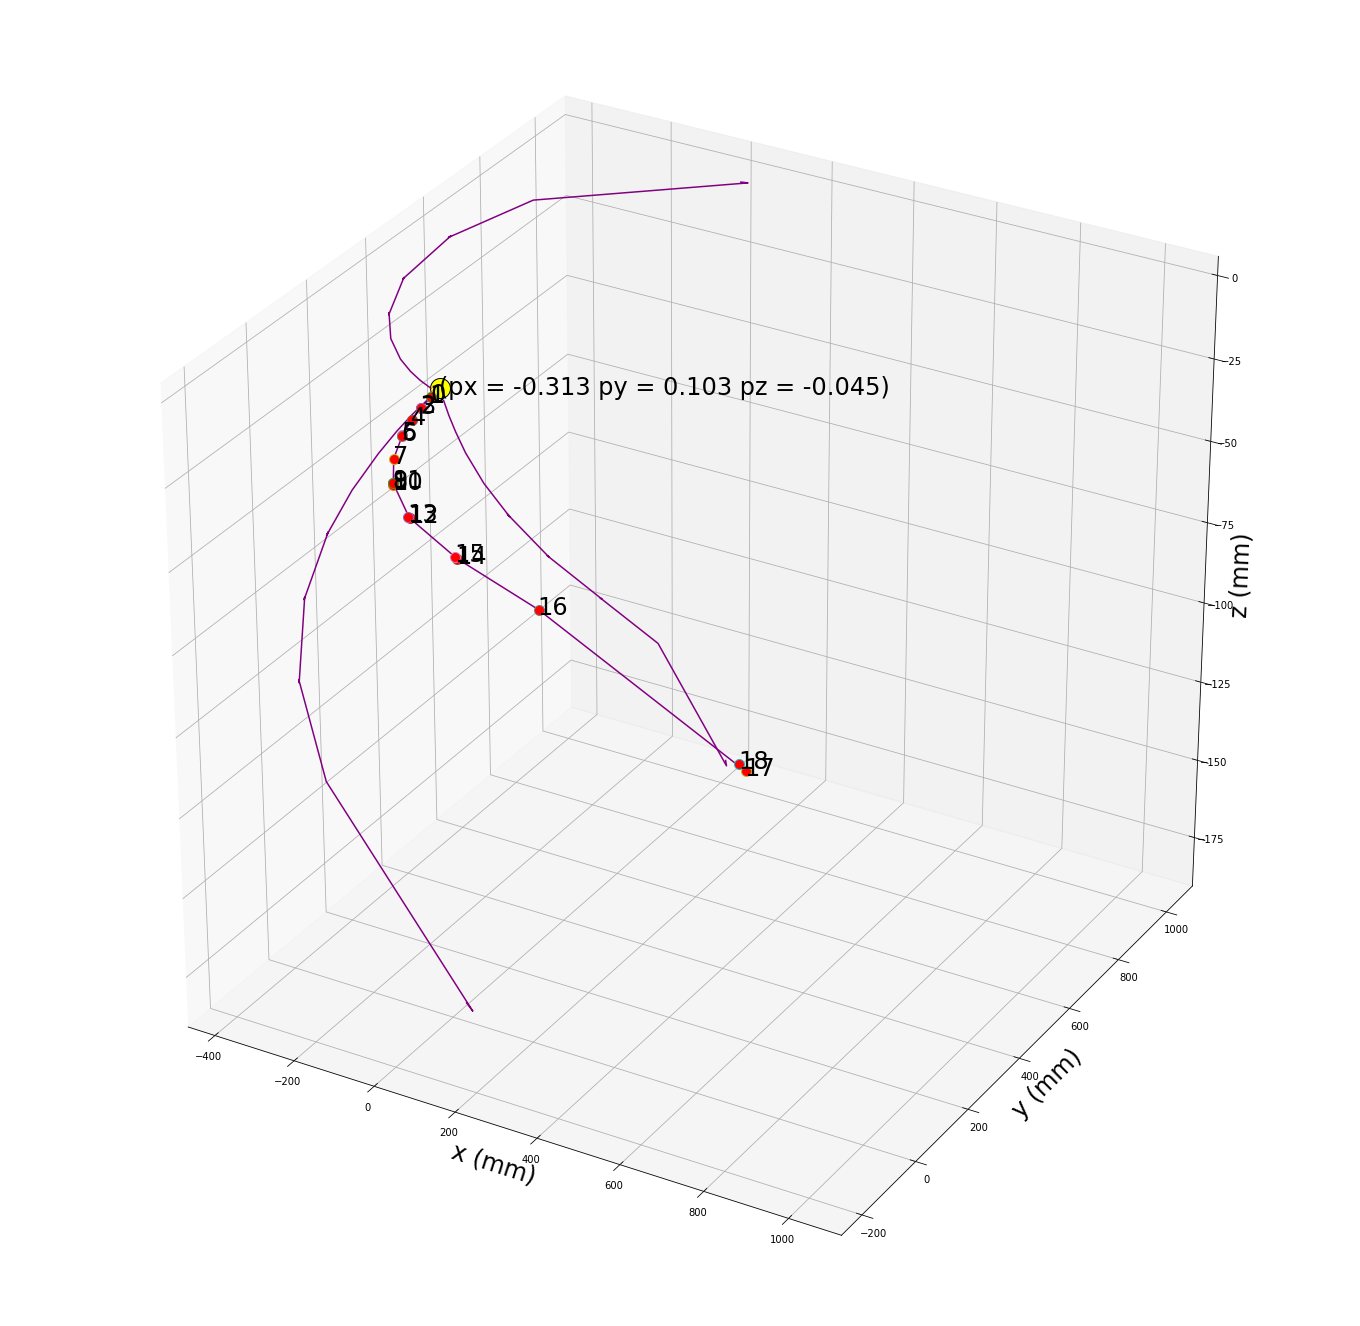

In [121]:
for i, particle_tuple in enumerate(first_group.iterrows()):
    fig = plt.figure(figsize=(24, 24))
    ax = fig.add_subplot(111, projection='3d')
    particle_description = particle_tuple[1]
    #print(particle_description)
    #print(particle_description)
    #print(particle_description)
    #print(particle_origin)
    particle_truth = truth[truth.particle_id == particle_description.particle_id]
    #print('particle_truth: ', particle_truth)
    '''
    ax.plot3D(
        [particle_description.vz],
        [particle_description.vx],
        [particle_description.vy],
        marker='o',
        color='black',
        #size=10
        #label=str(i)
    )
    '''
    ax.plot(
        [particle_description.vx],
        [particle_description.vy],
        [particle_description.vz],
        markerfacecolor='yellow',
        markeredgecolor='black',
        marker='o',
        markersize=20,
    )
    ax.text(
        particle_description.vx - 2,
        particle_description.vy - 2,
        particle_description.vz - 2,
        s="(px = {} py = {} pz = {})".format(
            round(particle_description.px, 3),
            round(particle_description.py, 3),
            round(particle_description.pz, 3),
        ),
        fontsize=24
    )
    '''
    ax.scatter(
        [particle_description.vx],
        [particle_description.vy],
        [particle_description.vz],
        c='red',
        marker='o',
        s=50
    )
    '''
    #ax.plot3D(particle_truth.tz, particle_truth.tx, particle_truth.ty, color='blue')
    ax.plot(particle_truth.tx, particle_truth.ty, particle_truth.tz, color='purple')
    ax.plot(particle_truth.tx, particle_truth.ty, zs=0, zdir='z', color='purple')
    ax.plot(particle_truth.tx, particle_truth.tz, zs=0, zdir='y', color='purple')
    ax.plot(particle_truth.ty, particle_truth.tz, zs=0, zdir='x', color='purple')
    for i, t_coords in enumerate(zip(particle_truth.tx, particle_truth.ty, particle_truth.tz)):
        tx, ty, tz = t_coords
        ax.plot(
            [tx],
            [ty],
            [tz],
            markerfacecolor='red',
            #markeredgecolor='black',
            marker='o',
            markersize=10,
            label=str(i)
        )
        ax.text(tx - 1.5, ty - 1.5 , tz - 1.5, s=str(i), fontsize=24)
        
    '''
    ax.scatter(
        particle_truth.tx,
        particle_truth.ty,
        particle_truth.tz,
        c='green',
        marker='o',
        s=100
    )
    '''
    #ax.scatter(3000, 3000,3000, s=0)
    #ax.scatter(-3000, -3000, -3000, s=0)
    #ax.quiver([0],[0], [0], [20], [0], [0])
    ax.set_xlabel("x (mm)", fontsize=24)
    ax.set_ylabel("y (mm)", fontsize=24)
    ax.set_zlabel("z (mm)", fontsize=24)
    plt.show()